# ACM Project – Bundestag Analysis

In [22]:
import os
import re
import json
import time
import requests
from tqdm import tqdm
import math
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt


## A. Automated data collection

### Query data from Bundestag API

In [28]:
# config
QUERY_API_FLAG = True

API_KEY = "OSOegLs.PR2lwJ1dwCeje9vTj7FPOt3hvpYKtwKkhw"
API_BASE_URL = "https://search.dip.bundestag.de/api/v1/plenarprotokoll"
API_GRACE_PERIOD = 0.3

BASE_DIR = "data"
META_DIR = f"{BASE_DIR}/meta"
XML_DIR = f"{BASE_DIR}/xml"
REF_DOC_DIR = f"{BASE_DIR}/docs"

RESULTS_DIR = f"{BASE_DIR}/results"

In [29]:
# --- Robust DIP downloader (21st WP, year 2025) ---
# - Handles cursor pagination (no missing pages)
# - Filters by date range at source
# - Saves protocol meta JSON
# - Downloads XML if available, otherwise PDF fallback
# - Fetches *complete* Vorgang references via f.plenarprotokoll (optional)

if QUERY_API_FLAG:
    # ---------- config ----------
    YEAR_START = "2025-01-01"
    YEAR_END   = "2025-12-31"

    TIMEOUT = 30
    MAX_RETRIES = 3
    FETCH_VORGAENGE = True

    PDF_DIR = f"{BASE_DIR}/pdf"
    os.makedirs(META_DIR, exist_ok=True)
    os.makedirs(XML_DIR, exist_ok=True)
    os.makedirs(PDF_DIR, exist_ok=True)
    os.makedirs(REF_DOC_DIR, exist_ok=True)

    session = requests.Session()

    def get_json(url, params=None):
        last_err = None
        for _ in range(MAX_RETRIES):
            try:
                r = session.get(url, params=params, timeout=TIMEOUT)
                r.raise_for_status()
                return r.json()
            except Exception as e:
                last_err = e
                time.sleep(API_GRACE_PERIOD * 3)
        raise last_err

    def get_bytes(url):
        last_err = None
        for _ in range(MAX_RETRIES):
            try:
                r = session.get(url, timeout=TIMEOUT)
                r.raise_for_status()
                return r.content
            except Exception as e:
                last_err = e
                time.sleep(API_GRACE_PERIOD * 3)
        raise last_err

    # ---------- 1) list all protocol IDs via cursor pagination ----------
    ids = []
    cursor = None

    base_params = {
        "f.wahlperiode": 21,
        "f.zuordnung": "BT",          # restrict to Bundestag at source
        "f.datum.start": YEAR_START,  # restrict to 2025 at source
        "f.datum.end": YEAR_END,
        "format": "json",
        "apikey": API_KEY,
    }

    while True:
        params = dict(base_params)
        if cursor:
            params["cursor"] = cursor

        data = get_json(API_BASE_URL, params=params)
        docs = data.get("documents", [])
        ids.extend([d["id"] for d in docs if "id" in d])

        new_cursor = data.get("cursor")
        if not new_cursor or new_cursor == cursor or len(docs) == 0:
            break
        cursor = new_cursor

        time.sleep(API_GRACE_PERIOD)

    ids = list(dict.fromkeys(ids))  # de-dup, keep order
    print(f"[API] Found {len(ids)} protocols for WP=21 in 2025.")

    # Save a manifest of fetched IDs
    manifest_path = os.path.join(META_DIR, "manifest_wp21_2025.json")
    with open(manifest_path, "w", encoding="utf-8") as f:
        json.dump({"wahlperiode": 21, "start": YEAR_START, "end": YEAR_END, "ids": ids}, f, ensure_ascii=False, indent=2)
    print(f"[API] Saved manifest: {manifest_path}")

    # ---------- 2) download each protocol meta + XML/PDF ----------
    stats = {"meta_saved": 0, "xml_saved": 0, "pdf_saved": 0, "skipped": 0, "vorgang_saved": 0}

    for pid in tqdm(ids, desc="Downloading protocols", unit="doc"):
        try:
            protocol_url = f"{API_BASE_URL}/{pid}"

            protocol = get_json(protocol_url, params={"format": "json", "apikey": API_KEY})

            # Defensive checks (avoid fragile title-based filters)
            if str(protocol.get("dokumentart", "")).lower() != "plenarprotokoll":
                stats["skipped"] += 1
                continue
            if protocol.get("herausgeber") != "BT":
                stats["skipped"] += 1
                continue

            # Save protocol meta JSON
            out_path = os.path.join(META_DIR, f"{pid}.json")
            with open(out_path, "w", encoding="utf-8") as f:
                json.dump(protocol, f, ensure_ascii=False, indent=2)
            stats["meta_saved"] += 1

            # ---------- 2a) optional: fetch full Vorgang references (NOT the preview list) ----------
            if FETCH_VORGAENGE:
                vorgang_base = "https://search.dip.bundestag.de/api/v1/vorgang"
                v_cursor = None
                while True:
                    v_params = {
                        "apikey": API_KEY,
                        "format": "json",
                        "f.plenarprotokoll": pid,  # full list of linked processes
                    }
                    if v_cursor:
                        v_params["cursor"] = v_cursor

                    vdata = get_json(vorgang_base, params=v_params)
                    vdocs = vdata.get("documents", [])

                    for vd in vdocs:
                        ref_id = vd.get("id")
                        if not ref_id:
                            continue
                        # save the vorgang "summary" doc directly (already useful)
                        ref_path = os.path.join(REF_DOC_DIR, f"{ref_id}.json")
                        if not os.path.exists(ref_path):
                            with open(ref_path, "w", encoding="utf-8") as vf:
                                json.dump(vd, vf, ensure_ascii=False, indent=2)
                            stats["vorgang_saved"] += 1

                    new_v_cursor = vdata.get("cursor")
                    if not new_v_cursor or new_v_cursor == v_cursor or len(vdocs) == 0:
                        break
                    v_cursor = new_v_cursor
                    time.sleep(API_GRACE_PERIOD)

            # ---------- 2b) download XML if present; else PDF fallback ----------
            fundstelle = protocol.get("fundstelle") or {}
            xml_url = fundstelle.get("xml_url")
            pdf_url = fundstelle.get("pdf_url")

            if xml_url:
                content = get_bytes(xml_url)
                with open(os.path.join(XML_DIR, f"{pid}.xml"), "wb") as xf:
                    xf.write(content)
                stats["xml_saved"] += 1
            elif pdf_url:
                content = get_bytes(pdf_url)
                with open(os.path.join(PDF_DIR, f"{pid}.pdf"), "wb") as pf:
                    pf.write(content)
                stats["pdf_saved"] += 1
            else:
                tqdm.write(f"[API][WARN] No xml_url/pdf_url for protocol {pid}")
                stats["skipped"] += 1

            time.sleep(API_GRACE_PERIOD)

        except Exception as e:
            tqdm.write(f"[API][ERROR] pid={pid}: {e}")
            stats["skipped"] += 1
            time.sleep(API_GRACE_PERIOD * 2)

    print("\n[API] Done.")
    print(json.dumps(stats, indent=2))
    print(f"[API] XML dir: {XML_DIR}")
    print(f"[API] PDF dir: {PDF_DIR}")
    print(f"[API] META dir: {META_DIR}")
    print(f"[API] REF dir: {REF_DOC_DIR}")

[API] Found 51 protocols for WP=21 in 2025.
[API] Saved manifest: data/meta/manifest_wp21_2025.json



[API] Done.
{
  "meta_saved": 51,
  "xml_saved": 49,
  "pdf_saved": 2,
  "skipped": 0,
  "vorgang_saved": 1880
}
[API] XML dir: data/xml
[API] PDF dir: data/pdf
[API] META dir: data/meta
[API] REF dir: data/docs


## B. Data preprocessing

### Descriptive analysis of downloaded data

In [30]:
import xml.etree.ElementTree as ET
import pandas as pd
from pathlib import Path

In [31]:
# ============================================================================
# DESCRIPTIVE ANALYSIS OF DOWNLOADED FILES
# ============================================================================

print("="*80)
print("DESCRIPTIVE ANALYSIS OF DOWNLOADED DATA")
print("="*80)

# --- 1. Directory Overview ---
print("\n1. DIRECTORY OVERVIEW")
print("-" * 80)

dirs_info = {
    "META files": META_DIR,
    "XML files": XML_DIR,
    "PDF files": f"{BASE_DIR}/pdf",
    "Reference docs (Vorgänge)": REF_DOC_DIR
}

for name, path in dirs_info.items():
    if os.path.exists(path):
        files = [f for f in os.listdir(path) if not f.startswith('.')]
        print(f"{name:30s}: {len(files):4d} files in {path}")
    else:
        print(f"{name:30s}: Directory not found")

# --- 2. META Files Analysis ---
print("\n\n2. META FILES ANALYSIS (Plenarprotokolle)")
print("-" * 80)

meta_files = [f for f in os.listdir(META_DIR) if f.endswith('.json') and f != 'manifest_wp21_2025.json']
print(f"Total meta files: {len(meta_files)}")

if meta_files:
    # Analyze a sample of meta files
    meta_data = []
    for fname in meta_files[:10]:  # Sample first 10
        with open(os.path.join(META_DIR, fname), 'r', encoding='utf-8') as f:
            data = json.load(f)
            meta_data.append({
                'id': data.get('id'),
                'datum': data.get('datum'),
                'dokumentart': data.get('dokumentart'),
                'herausgeber': data.get('herausgeber'),
                'wahlperiode': data.get('wahlperiode'),
                'has_xml': bool(data.get('fundstelle', {}).get('xml_url')),
                'has_pdf': bool(data.get('fundstelle', {}).get('pdf_url'))
            })
    
    meta_df = pd.DataFrame(meta_data)
    print("\nSample of meta data (first 10 files):")
    print(meta_df.to_string(index=False))
    
    print(f"\nXML availability: {meta_df['has_xml'].sum()}/{len(meta_df)} files")
    print(f"PDF availability: {meta_df['has_pdf'].sum()}/{len(meta_df)} files")

# --- 3. XML Files Analysis ---
print("\n\n3. XML FILES ANALYSIS")
print("-" * 80)

xml_files = [f for f in os.listdir(XML_DIR) if f.endswith('.xml')]
print(f"Total XML files: {len(xml_files)}")

if xml_files:
    # Get file sizes
    xml_sizes = []
    for fname in xml_files:
        fpath = os.path.join(XML_DIR, fname)
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        xml_sizes.append(size_mb)
    
    xml_sizes = np.array(xml_sizes)
    print(f"\nXML file sizes (MB):")
    print(f"  Total size: {xml_sizes.sum():.2f} MB")
    print(f"  Mean size:  {xml_sizes.mean():.2f} MB")
    print(f"  Median:     {np.median(xml_sizes):.2f} MB")
    print(f"  Min:        {xml_sizes.min():.2f} MB")
    print(f"  Max:        {xml_sizes.max():.2f} MB")

# --- 4. PDF Files Analysis ---
print("\n\n4. PDF FILES ANALYSIS")
print("-" * 80)

pdf_dir = f"{BASE_DIR}/pdf"
if os.path.exists(pdf_dir):
    pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]
    print(f"Total PDF files: {len(pdf_files)}")
    
    if pdf_files:
        pdf_sizes = []
        for fname in pdf_files:
            fpath = os.path.join(pdf_dir, fname)
            size_mb = os.path.getsize(fpath) / (1024 * 1024)
            pdf_sizes.append(size_mb)
        
        pdf_sizes = np.array(pdf_sizes)
        print(f"\nPDF file sizes (MB):")
        print(f"  Total size: {pdf_sizes.sum():.2f} MB")
        print(f"  Mean size:  {pdf_sizes.mean():.2f} MB")
else:
    print("PDF directory not found")

# --- 5. Reference Documents (Vorgänge) Analysis ---
print("\n\n5. REFERENCE DOCUMENTS (VORGÄNGE) ANALYSIS")
print("-" * 80)

ref_files = [f for f in os.listdir(REF_DOC_DIR) if f.endswith('.json')]
print(f"Total Vorgang reference files: {len(ref_files)}")

if ref_files:
    # Sample and analyze Vorgänge
    vorgang_types = {}
    vorgang_initiatives = {}
    
    for fname in ref_files[:100]:  # Sample first 100
        with open(os.path.join(REF_DOC_DIR, fname), 'r', encoding='utf-8') as f:
            data = json.load(f)
            vtyp = data.get('vorgangstyp', 'Unknown')
            vorgang_types[vtyp] = vorgang_types.get(vtyp, 0) + 1
            
            initiative = data.get('initiative', ['Unknown'])[0] if data.get('initiative') else 'Unknown'
            vorgang_initiatives[initiative] = vorgang_initiatives.get(initiative, 0) + 1
    
    print(f"\nVorgangstyp distribution (sample of 100):")
    for vtyp, count in sorted(vorgang_types.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {vtyp:40s}: {count:3d}")
    
    print(f"\nInitiative distribution (sample of 100):")
    for init, count in sorted(vorgang_initiatives.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {init:40s}: {count:3d}")

# --- 6. Temporal Coverage ---
print("\n\n6. TEMPORAL COVERAGE")
print("-" * 80)

dates = []
for fname in meta_files:
    with open(os.path.join(META_DIR, fname), 'r', encoding='utf-8') as f:
        data = json.load(f)
        if 'datum' in data:
            dates.append(data['datum'])

if dates:
    dates_sorted = sorted(dates)
    print(f"Date range: {dates_sorted[0]} to {dates_sorted[-1]}")
    print(f"Total protocols: {len(dates)}")
    
    # Count by month
    from collections import Counter
    months = [d[:7] for d in dates]  # YYYY-MM
    month_counts = Counter(months)
    
    print(f"\nProtocols by month:")
    for month in sorted(month_counts.keys()):
        print(f"  {month}: {month_counts[month]:2d} protocols")

# --- 7. Summary Statistics ---
print("\n\n7. SUMMARY STATISTICS")
print("=" * 80)
print(f"✓ Meta files (protocols):     {len(meta_files):4d}")
print(f"✓ XML files:                   {len(xml_files):4d}")
print(f"✓ PDF files:                   {len(pdf_files) if os.path.exists(pdf_dir) else 0:4d}")
print(f"✓ Reference documents:         {len(ref_files):4d}")
print(f"✓ Wahlperiode:                 21")
print(f"✓ Year:                        2025")
print("=" * 80)


DESCRIPTIVE ANALYSIS OF DOWNLOADED DATA

1. DIRECTORY OVERVIEW
--------------------------------------------------------------------------------
META files                    :   52 files in data/meta
XML files                     :   49 files in data/xml
PDF files                     :    2 files in data/pdf
Reference docs (Vorgänge)     : 1880 files in data/docs


2. META FILES ANALYSIS (Plenarprotokolle)
--------------------------------------------------------------------------------
Total meta files: 51

Sample of meta data (first 10 files):
  id      datum     dokumentart herausgeber  wahlperiode  has_xml  has_pdf
5708 2025-05-16 Plenarprotokoll          BT           21     True     True
5749 2025-11-14 Plenarprotokoll          BT           21     True     True
5732 2025-09-23 Plenarprotokoll          BT           21     True     True
5724 2025-07-10 Plenarprotokoll          BT           21     True     True
5753 2025-11-27 Plenarprotokoll          BT           21     True     True

Creating visualizations of downloaded data...


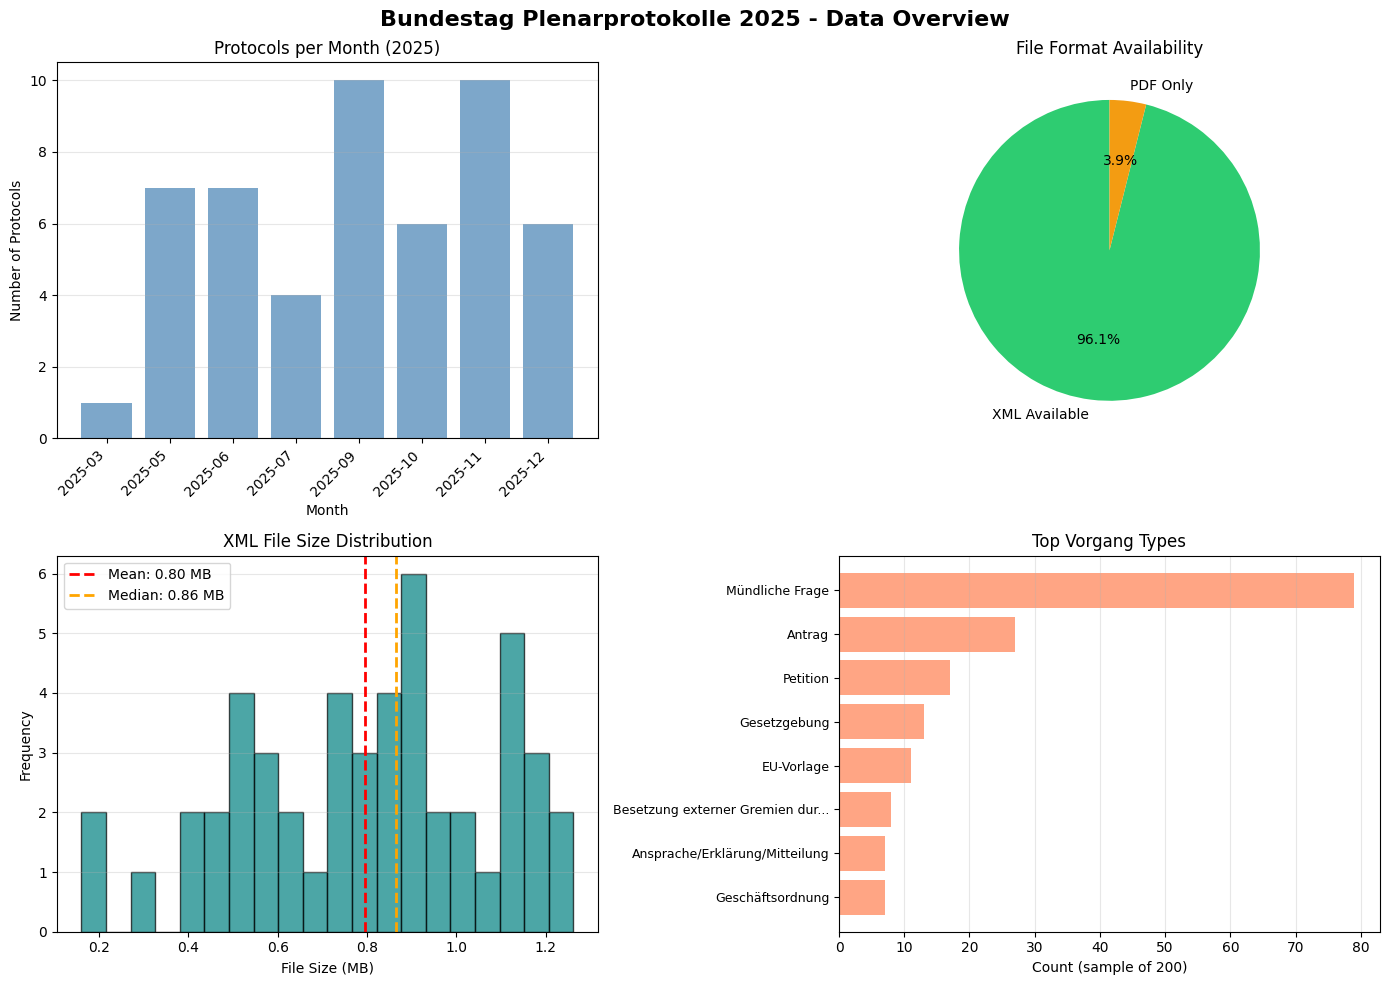

In [37]:
# ============================================================================
# VISUALIZATIONS OF DOWNLOADED DATA
# ============================================================================

print("Creating visualizations of downloaded data...")

# --- 1. Load all meta files for visualization ---
meta_files = [f for f in os.listdir(META_DIR) if f.endswith('.json') and f != 'manifest_wp21_2025.json']
meta_list = []

for fname in meta_files:
    with open(os.path.join(META_DIR, fname), 'r', encoding='utf-8') as f:
        data = json.load(f)
        meta_list.append({
            'id': data.get('id'),
            'datum': data.get('datum'),
            'wahlperiode': data.get('wahlperiode'),
            'has_xml': bool(data.get('fundstelle', {}).get('xml_url')),
            'has_pdf': bool(data.get('fundstelle', {}).get('pdf_url'))
        })

meta_viz_df = pd.DataFrame(meta_list)
meta_viz_df['date'] = pd.to_datetime(meta_viz_df['datum'], format='%Y-%m-%d')
meta_viz_df['month'] = meta_viz_df['date'].dt.to_period('M').astype(str)

# --- Create figure with subplots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Bundestag Plenarprotokolle 2025 - Data Overview', fontsize=16, fontweight='bold')

# --- Plot 1: Protocols over time ---
ax1 = axes[0, 0]
month_counts = meta_viz_df['month'].value_counts().sort_index()
ax1.bar(range(len(month_counts)), month_counts.values, color='steelblue', alpha=0.7)
ax1.set_xticks(range(len(month_counts)))
ax1.set_xticklabels(month_counts.index, rotation=45, ha='right')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Protocols')
ax1.set_title('Protocols per Month (2025)')
ax1.grid(axis='y', alpha=0.3)

# --- Plot 2: File format availability ---
ax2 = axes[0, 1]
format_data = {
    'XML Available': meta_viz_df['has_xml'].sum(),
    'PDF Only': meta_viz_df['has_pdf'].sum() - meta_viz_df['has_xml'].sum(),
    'Neither': len(meta_viz_df) - meta_viz_df['has_xml'].sum() - meta_viz_df['has_pdf'].sum()
}
colors = ['#2ecc71', '#f39c12', '#e74c3c']
wedges, texts, autotexts = ax2.pie(
    [v for v in format_data.values() if v > 0],
    labels=[k for k, v in format_data.items() if v > 0],
    autopct='%1.1f%%',
    colors=colors[:len([v for v in format_data.values() if v > 0])],
    startangle=90
)
ax2.set_title('File Format Availability')

# --- Plot 3: XML file sizes ---
ax3 = axes[1, 0]
xml_files = [f for f in os.listdir(XML_DIR) if f.endswith('.xml')]
if xml_files:
    xml_sizes_mb = []
    for fname in xml_files:
        fpath = os.path.join(XML_DIR, fname)
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        xml_sizes_mb.append(size_mb)
    
    ax3.hist(xml_sizes_mb, bins=20, color='teal', alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(xml_sizes_mb), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(xml_sizes_mb):.2f} MB')
    ax3.axvline(np.median(xml_sizes_mb), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(xml_sizes_mb):.2f} MB')
    ax3.set_xlabel('File Size (MB)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('XML File Size Distribution')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

# --- Plot 4: Vorgang types (if available) ---
ax4 = axes[1, 1]
ref_files = [f for f in os.listdir(REF_DOC_DIR) if f.endswith('.json')]
if ref_files:
    vorgang_types = {}
    for fname in ref_files[:200]:  # Sample 200 for speed
        with open(os.path.join(REF_DOC_DIR, fname), 'r', encoding='utf-8') as f:
            data = json.load(f)
            vtyp = data.get('vorgangstyp', 'Unknown')
            vorgang_types[vtyp] = vorgang_types.get(vtyp, 0) + 1
    
    # Get top 8 types
    top_types = sorted(vorgang_types.items(), key=lambda x: x[1], reverse=True)[:8]
    types, counts = zip(*top_types)
    
    # Truncate long names
    types_short = [t[:30] + '...' if len(t) > 30 else t for t in types]
    
    ax4.barh(range(len(types_short)), counts, color='coral', alpha=0.7)
    ax4.set_yticks(range(len(types_short)))
    ax4.set_yticklabels(types_short, fontsize=9)
    ax4.set_xlabel('Count (sample of 200)')
    ax4.set_title('Top Vorgang Types')
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()

plt.tight_layout()
plt.show()

### Descriptive analysis of speeches

In [38]:
# ============================================================================
# XML PARSING: Extract Speeches from Plenarprotokolle
# ============================================================================

import xml.etree.ElementTree as ET
import re

def parse_xml_protocol(xml_path):
    """
    Parse a single XML protocol file and extract all speeches with metadata,
    including Tagesordnungspunkt (TOP) information.
    
    Returns:
        List of dictionaries containing speech data
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Extract session metadata
    session_nr = root.get('sitzung-nr', '')
    session_date = root.get('sitzung-datum', '')
    wahlperiode = root.get('wahlperiode', '')
    
    # ========================================================================
    # STEP 1: Extract TOP structure from table of contents (Inhaltsverzeichnis)
    # ========================================================================
    top_mapping = {}  # Maps speech_id (rede id) to TOP info
    current_top_id = None
    current_top_title = None
    current_top_description = None
    
    # Find all ivz-block elements (agenda item blocks)
    for ivz_block in root.findall('.//ivz-block'):
        # Get the TOP title from ivz-block-titel
        top_titel_elem = ivz_block.find('ivz-block-titel')
        if top_titel_elem is not None and top_titel_elem.text:
            top_text = top_titel_elem.text.strip()
            
            # Extract TOP ID (e.g., "I.13", "III", "Tagesordnungspunkt I")
            # Try to extract structured TOP number
            top_match = re.search(r'(Tagesordnungspunkt\s+)?([IVX]+\.?\d*[a-z]?)', top_text, re.IGNORECASE)
            if top_match:
                current_top_id = top_match.group(2).strip()
            else:
                # Fallback: use the first part of the text
                current_top_id = top_text.split()[0] if top_text else 'Unknown'
            
            current_top_title = top_text
            
            # Extract TOP description from ivz-eintrag-inhalt (content descriptions)
            # Collect all content descriptions that are NOT speaker names
            descriptions = []
            for ivz_eintrag in ivz_block.findall('.//ivz-eintrag'):
                inhalt_elem = ivz_eintrag.find('ivz-eintrag-inhalt')
                if inhalt_elem is not None:
                    # Get text content, excluding speaker names (redner elements)
                    text_parts = []
                    if inhalt_elem.text:
                        text_parts.append(inhalt_elem.text.strip())
                    
                    # Check if this entry contains a speaker (redner) - if so, skip it
                    has_speaker = inhalt_elem.find('.//redner') is not None
                    
                    if not has_speaker and text_parts:
                        desc_text = ' '.join(text_parts).strip()
                        # Clean up common prefixes and whitespace
                        desc_text = re.sub(r'^[a-z]\)\s*', '', desc_text)  # Remove "a)", "b)", etc.
                        desc_text = re.sub(r'^\s+', '', desc_text)  # Remove leading whitespace
                        desc_text = re.sub(r'\s+', ' ', desc_text)  # Normalize whitespace
                        
                        # Skip entries that are just "Drucksachen" references
                        if desc_text and not desc_text.startswith('Drucksachen'):
                            descriptions.append(desc_text)
            
            # Combine descriptions (take first meaningful one, or combine first few)
            if descriptions:
                # Take the first substantial description (longer than 20 chars)
                substantial_desc = [d for d in descriptions if len(d) > 20]
                if substantial_desc:
                    current_top_description = substantial_desc[0][:200]  # Limit length
                else:
                    current_top_description = descriptions[0][:200] if descriptions else None
            else:
                current_top_description = None
            
            # Find all speeches (rede references) in this TOP block
            for ivz_eintrag in ivz_block.findall('.//ivz-eintrag'):
                # Look for xref elements that reference speeches
                for xref in ivz_eintrag.findall('.//xref[@ref-type="rede"]'):
                    rede_id = xref.get('rid', '')
                    if rede_id:
                        top_mapping[rede_id] = {
                            'top_id': current_top_id,
                            'top_title': current_top_title,
                            'top_description': current_top_description
                        }
    
    # ========================================================================
    # STEP 2: Extract speeches and match with TOP information
    # ========================================================================
    speeches = []
    
    # Find all speeches (rede elements)
    for rede in root.findall('.//rede'):
        speech_id = rede.get('id', '')
        
        # Get TOP information for this speech
        top_info = top_mapping.get(speech_id, {})
        top_id = top_info.get('top_id', None)
        top_title = top_info.get('top_title', None)
        top_description = top_info.get('top_description', None)
        
        # Extract speaker information
        redner = rede.find('.//redner')
        if redner is not None:
            speaker_id = redner.get('id', '')
            name_elem = redner.find('name')
            
            if name_elem is not None:
                vorname = name_elem.findtext('vorname', '').strip()
                nachname = name_elem.findtext('nachname', '').strip()
                titel = name_elem.findtext('titel', '').strip()
                fraktion = name_elem.findtext('fraktion', '').strip()
                
                # Extract rolle (nested structure: rolle/rolle_lang or rolle/rolle_kurz)
                rolle_elem = name_elem.find('rolle')
                if rolle_elem is not None:
                    rolle_lang = rolle_elem.findtext('rolle_lang', '').strip()
                    rolle_kurz = rolle_elem.findtext('rolle_kurz', '').strip()
                    rolle = rolle_lang if rolle_lang else rolle_kurz
                else:
                    rolle = ''
                
                # Construct full speaker name
                speaker_name = f"{titel} {vorname} {nachname}".strip()
            else:
                speaker_name = ''
                speaker_id = ''
                fraktion = ''
                rolle = ''
        else:
            speaker_name = ''
            speaker_id = ''
            fraktion = ''
            rolle = ''
        
        # Extract speech text from all <p> elements
        text_parts = []
        for p in rede.findall('.//p'):
            # Get text content, excluding comments
            p_text = []
            
            # Get initial text
            if p.text:
                p_text.append(p.text.strip())
            
            # Get text from child elements (but skip kommentar)
            for elem in p:
                if elem.tag != 'kommentar':
                    if elem.text:
                        p_text.append(elem.text.strip())
                if elem.tail:
                    p_text.append(elem.tail.strip())
            
            paragraph = ' '.join(p_text).strip()
            if paragraph:
                text_parts.append(paragraph)
        
        speech_text = ' '.join(text_parts)
        
        # Only add speeches with actual content
        if speech_text:
            speeches.append({
                'speech_id': speech_id,
                'session_nr': session_nr,
                'session_date': session_date,
                'wahlperiode': wahlperiode,
                'speaker_id': speaker_id,
                'speaker_name': speaker_name,
                'fraktion': fraktion,
                'rolle': rolle,
                'text': speech_text,
                'text_length': len(speech_text),
                'top_id': top_id,
                'top_title': top_title,
                'top_description': top_description
            })
    
    return speeches


# Parse all XML files
print("="*80)
print("PARSING XML PROTOCOLS")
print("="*80)

all_speeches = []
xml_files = list(Path(XML_DIR).glob("*.xml"))

print(f"\nFound {len(xml_files)} XML files to parse")
print("Parsing in progress...\n")

parse_errors = []

for xml_file in tqdm(xml_files, desc="Parsing XML files"):
    try:
        speeches = parse_xml_protocol(xml_file)
        all_speeches.extend(speeches)
    except Exception as e:
        parse_errors.append((xml_file.name, str(e)))
        print(f"\n⚠️  Error parsing {xml_file.name}: {e}")

# Create DataFrame
df_speeches = pd.DataFrame(all_speeches)

# ============================================================================
# CATEGORIZE SPEAKERS: Handle government officials without fraktion
# ============================================================================

def categorize_speaker(row):
    """
    Categorize speakers into meaningful groups.
    Government officials don't have fraktion but have rolle.
    """
    fraktion = str(row['fraktion']).strip()
    rolle = str(row['rolle']).strip()
    
    # Check if it's a government official (has rolle but no fraktion)
    if rolle and not fraktion:
        # Government roles
        if 'Bundeskanzler' in rolle:
            return 'Regierung', 'Bundeskanzler', 'Government'
        elif 'Bundesminister' in rolle or 'Ministerin' in rolle:
            return 'Regierung', 'Minister', 'Government'
        elif 'Staatssekretär' in rolle:
            return 'Regierung', 'Staatssekretär', 'Government'
        elif 'Präsident' in rolle or 'Vizepräsident' in rolle:
            return 'Präsidium', rolle, 'Presidency'
        else:
            return 'Sonstige', rolle, 'Other'
    
    # Regular MPs with fraktion
    elif fraktion:
        return fraktion, fraktion, 'Parliament'
    
    # Edge case: neither fraktion nor rolle
    else:
        return 'Unbekannt', 'Unbekannt', 'Unknown'

# Apply categorization
df_speeches[['speaker_category', 'speaker_group', 'speaker_type']] = df_speeches.apply(
    categorize_speaker, axis=1, result_type='expand'
)

print("\n" + "="*80)
print("PARSING RESULTS")
print("="*80)
print(f"✓ Files parsed successfully:  {len(xml_files) - len(parse_errors)}/{len(xml_files)}")
print(f"✓ Total speeches extracted:   {len(df_speeches):,}")
print(f"✓ Unique sessions:            {df_speeches['session_nr'].nunique()}")
print(f"✓ Unique speakers:            {df_speeches['speaker_id'].nunique()}")
print(f"✓ Date range:                 {df_speeches['session_date'].min()} to {df_speeches['session_date'].max()}")

if parse_errors:
    print(f"\n⚠️  Parsing errors: {len(parse_errors)}")
    for fname, error in parse_errors[:5]:
        print(f"   - {fname}: {error}")

PARSING XML PROTOCOLS

Found 49 XML files to parse
Parsing in progress...



Parsing XML files: 100%|██████████| 49/49 [00:00<00:00, 106.13it/s]


PARSING RESULTS
✓ Files parsed successfully:  49/49
✓ Total speeches extracted:   5,838
✓ Unique sessions:            49
✓ Unique speakers:            612
✓ Date range:                 03.12.2025 to 28.11.2025


In [39]:
# ============================================================================
# CREATE JSON WITH ALL TOP DESCRIPTIONS AND IDs
# ============================================================================

# Create session ID from wahlperiode + session_nr
df_speeches['session_id'] = (
    df_speeches['wahlperiode'].astype(str) + 
    df_speeches['session_nr'].astype(str).str.zfill(3)
)

# Get unique combinations
top_info = df_speeches[['session_id', 'session_nr', 'wahlperiode', 'top_id', 'top_title', 'top_description']].drop_duplicates()
top_info = top_info.dropna(subset=['top_id'])
top_info['unique_top_id'] = top_info['session_id'].astype(str) + '_' + top_info['top_id'].astype(str).str.replace(' ', '_')

# Count speeches per TOP
speech_counts = df_speeches.groupby(['session_id', 'top_id']).size().reset_index(name='speech_count')
speech_counts['unique_top_id'] = speech_counts['session_id'].astype(str) + '_' + speech_counts['top_id'].astype(str).str.replace(' ', '_')
top_info = top_info.merge(speech_counts[['unique_top_id', 'speech_count']], on='unique_top_id', how='left')

# Create JSON
tops_json = []
for _, row in top_info.iterrows():
    tops_json.append({
        'unique_id': row['unique_top_id'],
        'session_id': str(row['session_id']),
        'wahlperiode': str(row['wahlperiode']),
        'session_nr': str(row['session_nr']),
        'top_id': str(row['top_id']),
        'top_title': str(row['top_title']) if pd.notna(row['top_title']) else None,
        'description': str(row['top_description']) if pd.notna(row['top_description']) else None,
        'speech_count': int(row['speech_count']) if pd.notna(row['speech_count']) else 0
    })

tops_json = sorted(tops_json, key=lambda x: (x['session_id'], x['top_id']))

# Save
output_dir = os.path.join('data', 'results')
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'tops_with_descriptions.json')

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(tops_json, f, ensure_ascii=False, indent=2)

print(f"✓ Created {len(tops_json):,} unique TOPs")
print(f"✓ Saved to: {output_file}")

✓ Created 391 unique TOPs
✓ Saved to: data/results/tops_with_descriptions.json


✓ Saved parsed speeches to: data/results/speeches_parsed.csv
  Total rows: 5,838
  Columns: speech_id, session_nr, session_date, wahlperiode, speaker_id, speaker_name, fraktion, rolle, text, text_length, top_id, top_title, top_description, speaker_category, speaker_group, speaker_type, session_id



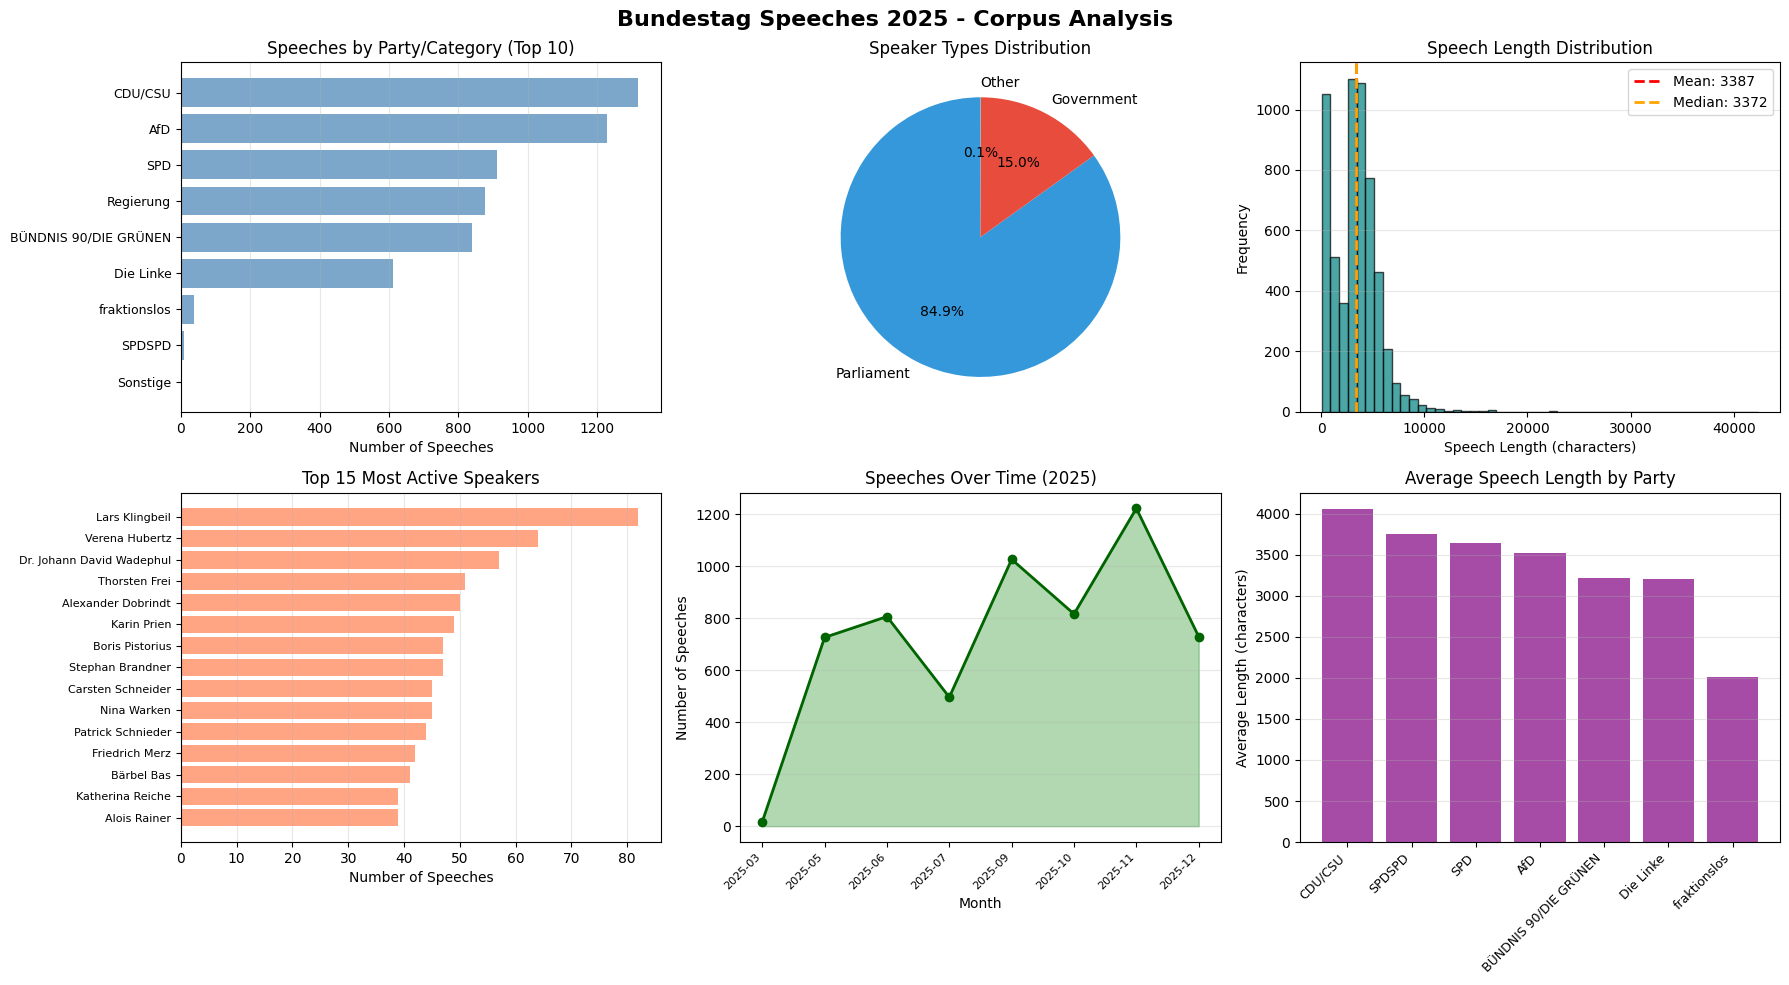

In [40]:
# ============================================================================
# VISUALIZE SPEECH CORPUS
# ============================================================================

# --- 1. Save the parsed speeches to CSV ---
os.makedirs(RESULTS_DIR, exist_ok=True)
output_path = f"{RESULTS_DIR}/speeches_parsed.csv"
df_speeches.to_csv(output_path, index=False, encoding='utf-8')
print(f"✓ Saved parsed speeches to: {output_path}")
print(f"  Total rows: {len(df_speeches):,}")
print(f"  Columns: {', '.join(df_speeches.columns)}\n")

# --- 2. Create visualizations of the speech corpus ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Bundestag Speeches 2025 - Corpus Analysis', fontsize=16, fontweight='bold')

# Plot 1: Speeches by Party/Category
ax1 = axes[0, 0]
party_counts = df_speeches['speaker_category'].value_counts().head(10)
ax1.barh(range(len(party_counts)), party_counts.values, color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(party_counts)))
ax1.set_yticklabels(party_counts.index, fontsize=9)
ax1.set_xlabel('Number of Speeches')
ax1.set_title('Speeches by Party/Category (Top 10)')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Government vs Parliament
ax2 = axes[0, 1]
type_counts = df_speeches['speaker_type'].value_counts()
colors_type = ['#3498db', '#e74c3c', '#95a5a6', '#f39c12']
wedges, texts, autotexts = ax2.pie(
    type_counts.values,
    labels=type_counts.index,
    autopct='%1.1f%%',
    colors=colors_type[:len(type_counts)],
    startangle=90
)
ax2.set_title('Speaker Types Distribution')

# Plot 3: Speech Length Distribution
ax3 = axes[0, 2]
speech_lengths = df_speeches['text_length']
ax3.hist(speech_lengths, bins=50, color='teal', alpha=0.7, edgecolor='black')
ax3.axvline(speech_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {speech_lengths.mean():.0f}')
ax3.axvline(speech_lengths.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {speech_lengths.median():.0f}')
ax3.set_xlabel('Speech Length (characters)')
ax3.set_ylabel('Frequency')
ax3.set_title('Speech Length Distribution')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Top 15 Most Active Speakers
ax4 = axes[1, 0]
top_speakers = df_speeches['speaker_name'].value_counts().head(15)
ax4.barh(range(len(top_speakers)), top_speakers.values, color='coral', alpha=0.7)
ax4.set_yticks(range(len(top_speakers)))
ax4.set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in top_speakers.index], fontsize=8)
ax4.set_xlabel('Number of Speeches')
ax4.set_title('Top 15 Most Active Speakers')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# Plot 5: Speeches Over Time
ax5 = axes[1, 1]
df_speeches['date'] = pd.to_datetime(df_speeches['session_date'], format='%d.%m.%Y', errors='coerce')
df_speeches['month'] = df_speeches['date'].dt.to_period('M').astype(str)
monthly_speeches = df_speeches.groupby('month').size().sort_index()
ax5.plot(range(len(monthly_speeches)), monthly_speeches.values, marker='o', linewidth=2, markersize=6, color='darkgreen')
ax5.fill_between(range(len(monthly_speeches)), monthly_speeches.values, alpha=0.3, color='green')
ax5.set_xticks(range(len(monthly_speeches)))
ax5.set_xticklabels(monthly_speeches.index, rotation=45, ha='right', fontsize=8)
ax5.set_xlabel('Month')
ax5.set_ylabel('Number of Speeches')
ax5.set_title('Speeches Over Time (2025)')
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Average Speech Length by Party
ax6 = axes[1, 2]
parl_only = df_speeches[df_speeches['speaker_type'] == 'Parliament']
avg_length_by_party = parl_only.groupby('speaker_category')['text_length'].mean().sort_values(ascending=False).head(8)
ax6.bar(range(len(avg_length_by_party)), avg_length_by_party.values, color='purple', alpha=0.7)
ax6.set_xticks(range(len(avg_length_by_party)))
ax6.set_xticklabels(avg_length_by_party.index, rotation=45, ha='right', fontsize=9)
ax6.set_ylabel('Average Length (characters)')
ax6.set_title('Average Speech Length by Party')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Quality filters

SPEECH ANALYSIS

1. LENGTH-BASED CLASSIFICATION

Length Distribution:
  Very Short (<500)   :  314 (  5.4%) | Avg:   359 chars
  Short (500-1k)      :  859 ( 14.7%) | Avg:   733 chars
  Medium (1-2k)       :  468 (  8.0%) | Avg:  1366 chars
  Long (2-5k)         : 3158 ( 54.1%) | Avg:  3607 chars
  Very Long (≥5k)     : 1039 ( 17.8%) | Avg:  6737 chars


2. DETAILED ANALYSIS: Finding the threshold for real speeches

Bucket             Count  Percent    Avg Len     Median
------------------------------------------------------------
0-200                 33     0.6%        122        117
200-500              281     4.8%        387        396
500-750              485     8.3%        631        633
750-1000             374     6.4%        866        858
1000-1500            328     5.6%       1199       1186
1500-2000            140     2.4%       1757       1770
2000-3000            750    12.8%       2646       2698
3000-5000          2,408    41.2%       3907       3872
5000-10000     

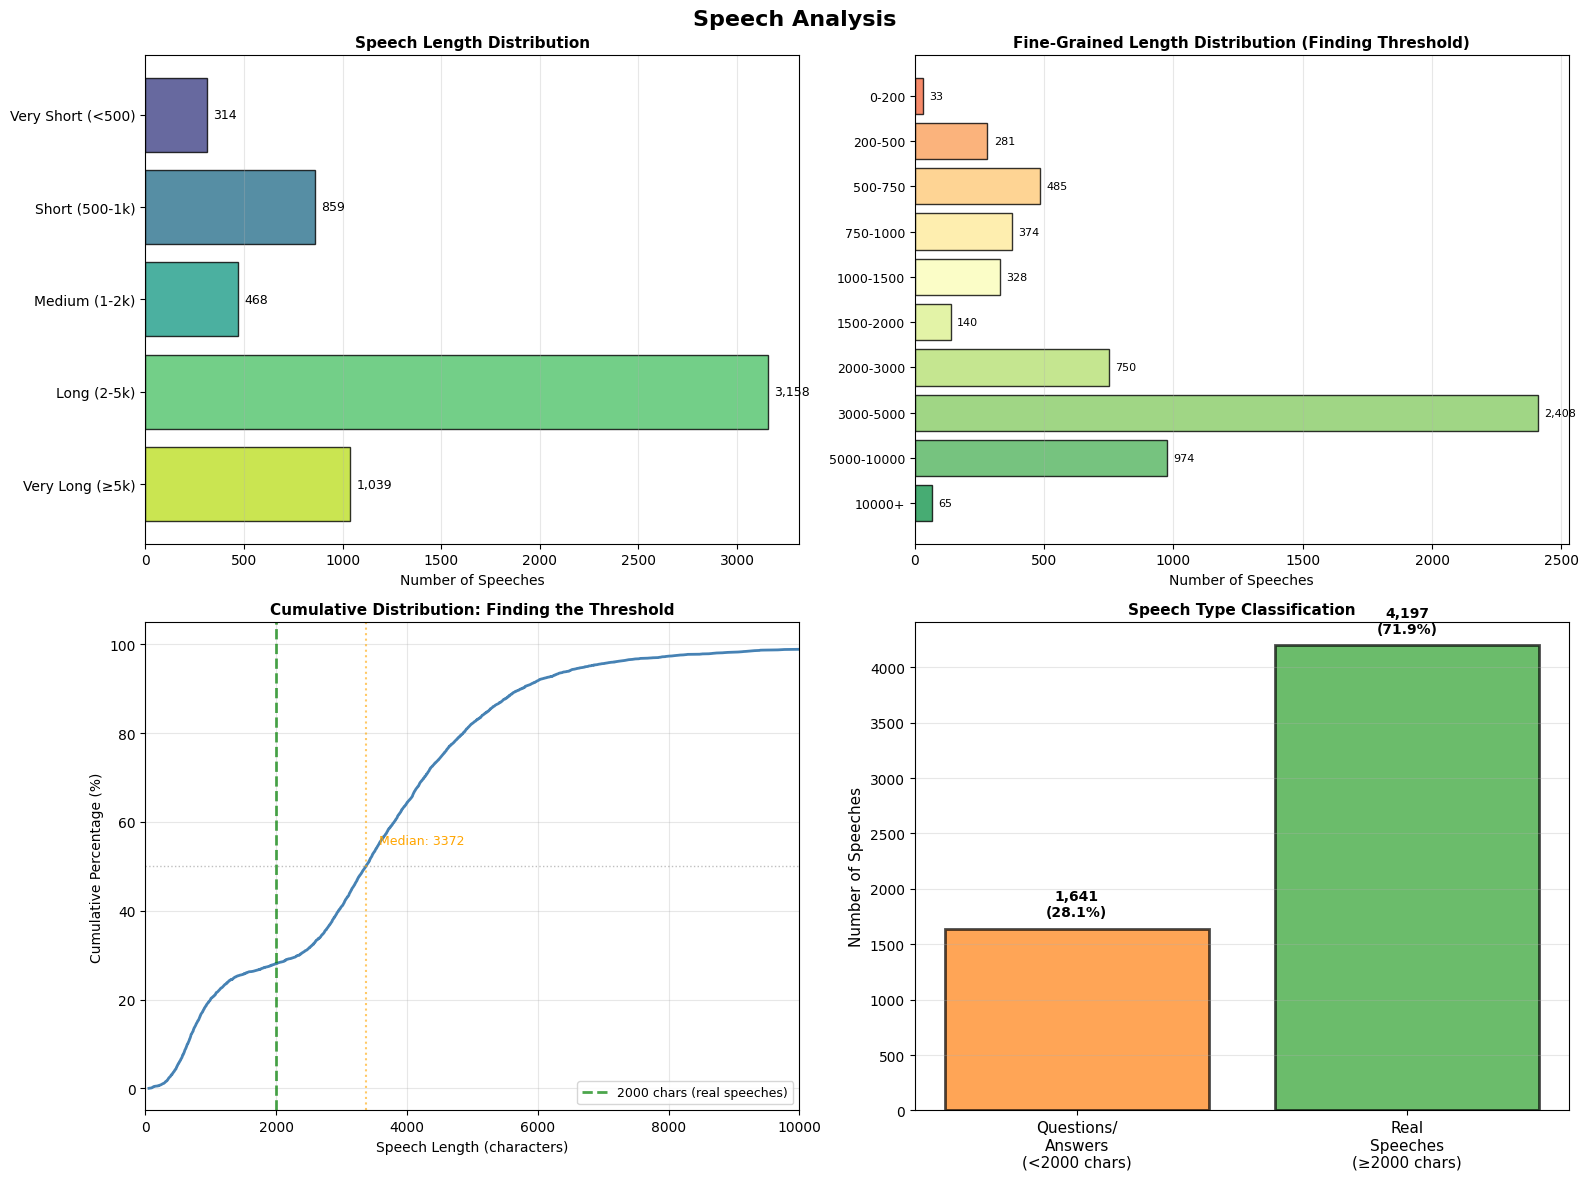


✓ Working dataframe updated to real speeches only (4,197 rows)
✓ Questions/Answers removed: 1,641 speeches


In [41]:
# ============================================================================
# SPEECH ANALYSIS
# ============================================================================

print("="*80)
print("SPEECH ANALYSIS")
print("="*80)

# --- 1. Basic length-based classification ---
print("\n1. LENGTH-BASED CLASSIFICATION\n")

def classify_by_length(length):
    """Simple classification based only on length."""
    if length < 500:
        return 'Very Short (<500)'
    elif length < 1000:
        return 'Short (500-1k)'
    elif length < 2000:
        return 'Medium (1-2k)'
    elif length < 5000:
        return 'Long (2-5k)'
    else:
        return 'Very Long (≥5k)'

df_speeches['length_class'] = df_speeches['text_length'].apply(classify_by_length)

print("Length Distribution:")
length_counts = df_speeches['length_class'].value_counts()
for lclass in ['Very Short (<500)', 'Short (500-1k)', 'Medium (1-2k)', 'Long (2-5k)', 'Very Long (≥5k)']:
    if lclass in length_counts.index:
        count = length_counts[lclass]
        pct = count / len(df_speeches) * 100
        avg_len = df_speeches[df_speeches['length_class'] == lclass]['text_length'].mean()
        print(f"  {lclass:20s}: {count:4d} ({pct:5.1f}%) | Avg: {avg_len:5.0f} chars")

# --- 2. Analyze speech types by length buckets ---
print("\n\n2. DETAILED ANALYSIS: Finding the threshold for real speeches\n")

# Create finer buckets to identify the threshold
length_buckets = [
    (0, 200, "0-200"),
    (200, 500, "200-500"),
    (500, 750, "500-750"),
    (750, 1000, "750-1000"),
    (1000, 1500, "1000-1500"),
    (1500, 2000, "1500-2000"),
    (2000, 3000, "2000-3000"),
    (3000, 5000, "3000-5000"),
    (5000, 10000, "5000-10000"),
    (10000, float('inf'), "10000+")
]

bucket_stats = []
for min_len, max_len, label in length_buckets:
    subset = df_speeches[(df_speeches['text_length'] >= min_len) & 
                         (df_speeches['text_length'] < max_len)].copy()
    
    if len(subset) > 0:
        bucket_stats.append({
            'bucket': label,
            'min': min_len,
            'max': max_len,
            'count': len(subset),
            'pct': len(subset) / len(df_speeches) * 100,
            'avg_len': subset['text_length'].mean(),
            'median_len': subset['text_length'].median(),
        })

print(f"{'Bucket':15s} {'Count':>8s} {'Percent':>8s} {'Avg Len':>10s} {'Median':>10s}")
print("-" * 60)
for stat in bucket_stats:
    print(f"{stat['bucket']:15s} {stat['count']:8,} {stat['pct']:7.1f}% {stat['avg_len']:10.0f} {stat['median_len']:10.0f}")

# --- 3. Show examples from critical length ranges ---
print("\n\n3. EXAMPLES FROM CRITICAL LENGTH RANGES\n")

critical_ranges = [
    (200, 500, "200-500 chars (Very Short)"),
    (750, 1000, "750-1000 chars (Upper Short)"),
    (1500, 2000, "1500-2000 chars (Upper Medium)"),
    (2500, 3000, "2500-3000 chars (Lower Long)"),
]

for min_len, max_len, label in critical_ranges:
    subset = df_speeches[(df_speeches['text_length'] >= min_len) & 
                         (df_speeches['text_length'] < max_len)].copy()
    
    print("=" * 80)
    print(f"{label}")
    print("=" * 80)
    print(f"Total: {len(subset):,} speeches\n")
    
    if len(subset) > 0:
        samples = subset.sample(min(3, len(subset)), random_state=42)
        
        for idx, row in samples.iterrows():
            text = row['text'][:2000] + '...' if len(row['text']) > 2000 else row['text']
            print(f"[{row['speaker_category']}] {row['speaker_name']} | {row['text_length']} chars")
            print(f"{text}")
            print("-" * 80)
            print()

# --- 4. Filter: Remove Questions/Answers (keep only real speeches) ---
print("\n4. FILTERING: REMOVING QUESTIONS/ANSWERS\n")

# Based on analysis, set threshold for "real speeches"
THRESHOLD_REAL_SPEECH = 2000

df_real_speeches = df_speeches[df_speeches['text_length'] >= THRESHOLD_REAL_SPEECH].copy()

print(f"Filtering Results:")
print(f"  Threshold for real speeches: {THRESHOLD_REAL_SPEECH} chars")
print(f"  Before filtering:            {len(df_speeches):,}")
print(f"  After filtering (≥{THRESHOLD_REAL_SPEECH}):  {len(df_real_speeches):,}")
print(f"  Removed (Q&A):               {len(df_speeches) - len(df_real_speeches):,} ({(1-len(df_real_speeches)/len(df_speeches))*100:.1f}%)")

# --- 5. Visualizations ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Speech Analysis', fontsize=16, fontweight='bold')

# Plot 1: Length distribution (original)
ax1 = axes[0, 0]
length_order = ['Very Short (<500)', 'Short (500-1k)', 'Medium (1-2k)', 'Long (2-5k)', 'Very Long (≥5k)']
length_counts_ordered = [length_counts.get(lc, 0) for lc in length_order]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(length_order)))
bars = ax1.barh(range(len(length_order)), length_counts_ordered, color=colors, alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(length_order)))
ax1.set_yticklabels(length_order, fontsize=10)
ax1.set_xlabel('Number of Speeches', fontsize=10)
ax1.set_title('Speech Length Distribution', fontsize=11, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, length_counts_ordered)):
    if count > 0:
        ax1.text(count + max(length_counts_ordered)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{count:,}', va='center', fontsize=9)

# Plot 2: Fine-grained length buckets
ax2 = axes[0, 1]
bucket_labels = [s['bucket'] for s in bucket_stats]
bucket_counts = [s['count'] for s in bucket_stats]
colors_bucket = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(bucket_labels)))
bars = ax2.barh(range(len(bucket_labels)), bucket_counts, color=colors_bucket, alpha=0.8, edgecolor='black')
ax2.set_yticks(range(len(bucket_labels)))
ax2.set_yticklabels(bucket_labels, fontsize=9)
ax2.set_xlabel('Number of Speeches', fontsize=10)
ax2.set_title('Fine-Grained Length Distribution (Finding Threshold)', fontsize=11, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for bar, count in zip(bars, bucket_counts):
    if count > 0:
        ax2.text(count + max(bucket_counts)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{count:,}', va='center', fontsize=8)

# Plot 3: Cumulative distribution to find threshold
ax3 = axes[1, 0]
sorted_lengths = np.sort(df_speeches['text_length'].values)
cumulative_pct = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
ax3.plot(sorted_lengths, cumulative_pct, linewidth=2, color='steelblue')
ax3.axvline(THRESHOLD_REAL_SPEECH, color='green', linestyle='--', linewidth=2, 
            label=f'{THRESHOLD_REAL_SPEECH} chars (real speeches)', alpha=0.7)
ax3.axhline(50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax3.set_xlabel('Speech Length (characters)', fontsize=10)
ax3.set_ylabel('Cumulative Percentage (%)', fontsize=10)
ax3.set_title('Cumulative Distribution: Finding the Threshold', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)
ax3.set_xlim(0, 10000)

# Add median annotation
median_len = df_speeches['text_length'].median()
ax3.axvline(median_len, color='orange', linestyle=':', linewidth=1.5, alpha=0.6)
ax3.text(median_len + 200, 55, f'Median: {median_len:.0f}', fontsize=9, color='orange')

# Plot 4: Questions/Answers vs Real Speeches comparison
ax4 = axes[1, 1]
qa_speeches = df_speeches[df_speeches['text_length'] < THRESHOLD_REAL_SPEECH].copy()

categories = ['Questions/\nAnswers\n(<2000 chars)', 'Real\nSpeeches\n(≥2000 chars)']
counts = [len(qa_speeches), len(df_real_speeches)]
colors_cat = ['#ff7f0e', '#2ca02c']
bars = ax4.bar(range(len(categories)), counts, color=colors_cat, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_xticks(range(len(categories)))
ax4.set_xticklabels(categories, fontsize=11)
ax4.set_ylabel('Number of Speeches', fontsize=11)
ax4.set_title('Speech Type Classification', fontsize=11, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, counts):
    pct = count / len(df_speeches) * 100
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.02,
             f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Update working dataframe to real speeches only
df_speeches = df_real_speeches.copy()
print(f"\n✓ Working dataframe updated to real speeches only ({len(df_speeches):,} rows)")
print(f"✓ Questions/Answers removed: {len(qa_speeches):,} speeches")

### Boilerplate removal

In [42]:
# ============================================================================
# TEXT CLEANING
# Based on discovered patterns from exploratory analysis
# ============================================================================

print("="*80)
print("TEXT CLEANING")
print("="*80)

import re
import pandas as pd

_DASHES = re.compile(r"[–—−]")
_WS = re.compile(r"\s+")

_GROUP_PREFIX = re.compile(r"^\s*\[[^\]\n]{2,40}\]\s*")

# allow lowercase name particles in German/European names
_NAME_PARTICLES = r"(?:von|van|vom|zu|zur|zum|de|del|della|da|di|dos|den|der|ter|ten|la|le|du)"

# Speaker header:
# - supports names with lowercase particles: "Catarina dos Santos-Wintz"
# - supports optional "(Partei)" and optional ", Rolle ..."
# - ends at ":" only at start of text
_SPEAKER_HEADER = re.compile(
    rf"^\s*"
    rf"(?:(?:Prof\.)\s*)?"                 # optional Prof.
    rf"(?:(?:Dr\.)\s*){{0,2}}"             # optional Dr. / Dr. Dr.
    rf"(?:"
    rf"[A-ZÄÖÜ][\wÄÖÜäöüß\-.]*"             # normal name token
    rf"|{_NAME_PARTICLES}"                 # OR lowercase particle
    rf")"
    rf"(?:\s+(?:[A-ZÄÖÜ][\wÄÖÜäöüß\-.]*|{_NAME_PARTICLES})){{0,10}}"  # up to 11 tokens
    rf"(?:\s*\([^)\n]{{2,80}}\))?"         # optional "(CDU/CSU)" etc.
    rf"(?:\s*,\s*[^:\n]{{2,220}})?"        # optional ", role/office"
    rf"\s*:\s*",
    flags=re.IGNORECASE | re.UNICODE
)

# Remove only typical stage directions (safer than deleting all parentheses)
_STAGE_DIR = re.compile(
    r"\(\s*(?:beifall|zuruf|zwischenruf|heiterkeit|widerspruch|unruhe|lachen|zustimmung|ablehnung|ruf|rufe|gegenruf|applaus)[^)]{0,220}\)",
    flags=re.IGNORECASE | re.UNICODE
)
_STAGE_DIR_BR = re.compile(
    r"\[\s*(?:beifall|zuruf|zwischenruf|heiterkeit|widerspruch|unruhe|lachen|zustimmung|ablehnung|ruf|rufe|gegenruf|applaus)[^\]]{0,220}\]",
    flags=re.IGNORECASE | re.UNICODE
)

# Opening salutations / housekeeping (strip iteratively from start)
_OPENERS = [
    # Präsidium (Präsident/in)
    r"^(?:frau|herr)\s+(?:präsidentin|präsident|vizepräsidentin|vizepräsident)\b[!\.,:\s-]*",
    r"^sehr\s+(?:geehrt(?:e|er|en)|verehrt(?:e|er|en))\s+(?:frau|herr)\s+"
    r"(?:präsidentin|präsident|vizepräsidentin|vizepräsident)\b[!\.,:\s-]*",

    # Minister/Regierungsamt (Anrede)
    r"^(?:frau|herr)\s+(?:ministerin|minister|staatsministerin|staatsminister|"
    r"staatssekretärin|staatssekretär|bundeskanzlerin|bundeskanzler)\b[!\.,:\s-]*",

    # Formelle Anrede Frau/Herr (ggf. mit Namen)
    r"^sehr\s+(?:geehrt(?:e|er|en)|verehrt(?:e|er|en))\s+(?:frau|herr)\b(?:\s+[a-zäöüß\-]+){0,6}[!\.,:\s-]*",
    r"^geehrt(?:e|er|en)\s+(?:frau|herr)\b(?:\s+[a-zäöüß\-]+){0,6}[!\.,:\s-]*",

    # Kolleg*innen (inkl. Varianten)
    r"^(?:meine\s+)?sehr\s+geehrt(?:en|e|er)\s+kolleginnen\s+und\s+kollegen\b[!\.,:\s-]*",
    r"^(?:meine\s+)?sehr\s+geehrt(?:en|e|er)\s+kollegen\b[!\.,:\s-]*",
    r"^(?:sehr\s+)?(?:geehrte|werte|liebe)\s+kolleginnen\s+und\s+kollegen\b[!\.,:\s-]*",
    r"^(?:sehr\s+)?(?:geehrte|werte|liebe)\s+kolleginnen\b[!\.,:\s-]*",
    r"^(?:sehr\s+)?(?:geehrte|werte|liebe)\s+kollegen\b[!\.,:\s-]*",
    r"^kolleginnen\s+und\s+kollegen\b[!\.,:\s-]*",

    # "geschätzte Kolleg*innen" + optional audience add-on
    r"^(?:sehr\s+)?geschätzte\s+kolleg(?:innen|en)\b"
    r"(?:\s+und\s+(?:zuschauer(?:innen|n)?|gäste|bürgerinnen\s+und\s+bürger|bürger|zuhörerinnen\s+und\s+zuhörer|zuhörer))?"
    r"[!\.,:\s-]*",

    # "liebe/werte Kolleg*innen und Zuschauer/Gäste"
    r"^(?:liebe|werte)\s+kolleg(?:innen|en)\b"
    r"(?:\s+und\s+(?:zuschauer(?:innen|n)?|gäste))?"
    r"[!\.,:\s-]*",

    # Damen und Herren
    r"^(?:meine\s+)?sehr\s+geehrt(?:en|e|er)\s+damen\s+und\s+herren\b[!\.,:\s-]*",
    r"^(?:sehr\s+)?(?:geehrte|meine|werte)\s+damen\s+und\s+herren\b[!\.,:\s-]*",
    r"^damen\s+und\s+herren\b[!\.,:\s-]*",

    # Publikum / Bürger / Gäste
    r"^(?:liebe|sehr\s+geehrte)\s+(?:bürgerinnen\s+und\s+bürger|bürger|"
    r"zuhörerinnen\s+und\s+zuhörer|zuhörer|gäste|freundinnen\s+und\s+freunde)\b[!\.,:\s-]*",

    # Grüße / Dank
    r"^(?:guten\s+(?:morgen|tag|abend)|hallo)\b[!\.,:\s-]*",
    r"^(?:vielen|besten|herzlichen)\s+dank\b[!\.,:\s-]*",
    r"^(?:ich\s+danke\s+ihnen|ich\s+bedanke\s+mich)\b[!\.,:\s-]*",
]
_OPENERS_RX = [re.compile(p, flags=re.IGNORECASE | re.UNICODE) for p in _OPENERS]

_CLOSING_RX = re.compile(
    r"(?:vielen\s+dank|herzlichen\s+dank|danke\s+schön|dankeschön|ich\s+danke\s+ihnen)\.?\s*$",
    flags=re.IGNORECASE | re.UNICODE
)

def clean_speech_text(text) -> str:
    if pd.isna(text):
        return ""

    t = str(text).strip()
    if not t:
        return ""

    t = _DASHES.sub("-", t)

    # remove optional "[AfD]" etc if it is inside the text field
    t = _GROUP_PREFIX.sub("", t).lstrip()

    # remove speaker header (now handles 'dos', 'von', etc.)
    t = _SPEAKER_HEADER.sub("", t).lstrip()

    # remove stage directions (only the common ones)
    for _ in range(2):
        t = _STAGE_DIR.sub("", t)
        t = _STAGE_DIR_BR.sub("", t)

    t = t.lstrip()

    # iteratively strip multiple openers (chains)
    for _ in range(12):
        before = t
        t = re.sub(r"^(?:\s*[-]+\s*)+", "", t)  # swallow leading separators

        for rx in _OPENERS_RX:
            m = rx.match(t)
            if m:
                t = t[m.end():].lstrip()
                break

        if t == before:
            break

    t = _CLOSING_RX.sub("", t).strip()
    t = _WS.sub(" ", t).strip()

    # normalize quotes (optional)
    t = t.replace("„", '"').replace(""", '"').replace(""", '"').replace("'", "'").replace("´", "'")

    return t

# Apply cleaning
print("\n1. Applying text cleaning...\n")

df_speeches['text_clean'] = df_speeches['text'].apply(clean_speech_text)
df_speeches['text_clean_length'] = df_speeches['text_clean'].str.len()

# Calculate cleaning impact
avg_reduction = (df_speeches['text_length'] - df_speeches['text_clean_length']).mean()
pct_reduction = (1 - df_speeches['text_clean_length'].mean() / df_speeches['text_length'].mean()) * 100

print(f"Cleaning Statistics:")
print(f"  Original avg length:     {df_speeches['text_length'].mean():.0f} chars")
print(f"  Cleaned avg length:      {df_speeches['text_clean_length'].mean():.0f} chars")
print(f"  Avg reduction:           {avg_reduction:.0f} chars ({pct_reduction:.1f}%)")
print(f"  Speeches with <50 chars: {(df_speeches['text_clean_length'] < 50).sum()}")

# Show examples
print("\n\n2. CLEANING EXAMPLES\n")

# Sample 10 random speeches to show before/after (reduced from 20)
samples = df_speeches.sample(min(10, len(df_speeches)), random_state=42)

for idx, row in samples.iterrows():
    print(f"[{row['speaker_category']}] {row['speaker_name']}")
    print(f"\nORIGINAL ({row['text_length']} chars):")
    print(row['text'][:400] + "..." if len(row['text']) > 400 else row['text'])
    print(f"\nCLEANED ({row['text_clean_length']} chars):")
    print(row['text_clean'][:400] + "..." if len(row['text_clean']) > 400 else row['text_clean'])
    print("\n" + "-"*80 + "\n")

# --- Filter 2: Remove opening patterns (very short cleaned speeches) ---
print("\n3. FILTER 2: REMOVING OPENING PATTERNS\n")

min_length_opening = 100
df_speeches_filtered = df_speeches[df_speeches['text_clean_length'] >= min_length_opening].copy()

print(f"Filtering Results (remove opening patterns after cleaning):")
print(f"  Original speeches:               {len(df_speeches):,}")
print(f"  After filtering (<{min_length_opening} cleaned): {len(df_speeches_filtered):,}")
print(f"  Removed (opening patterns):      {len(df_speeches) - len(df_speeches_filtered):,} ({(1-len(df_speeches_filtered)/len(df_speeches))*100:.1f}%)")

# Save cleaned data
print("\n\n4. SAVING CLEANED DATA\n")

output_path = f"{RESULTS_DIR}/speeches_cleaned.csv"
df_speeches_filtered.to_csv(output_path, index=False, encoding='utf-8')
print(f"✓ Saved cleaned speeches to: {output_path}")
print(f"  Rows: {len(df_speeches_filtered):,}")

# Update working dataframe
df_speeches = df_speeches_filtered.copy()
print(f"\n✓ Working dataframe updated ({len(df_speeches):,} rows)")
print(f"✓ Real speeches (≥2000 chars) cleaned, opening patterns removed")
print(f"✓ Ready for final analysis")

TEXT CLEANING

1. Applying text cleaning...

Cleaning Statistics:
  Original avg length:     4382 chars
  Cleaned avg length:      4298 chars
  Avg reduction:           84 chars (1.9%)
  Speeches with <50 chars: 0


2. CLEANING EXAMPLES

[AfD] Dr. Alice Weidel

ORIGINAL (13946 chars):
Dr. Alice Weidel (AfD): Sehr geehrte Frau Präsidentin! Sehr geehrter Herr Bundeskanzler! Sehr geehrte Damen und Herren! Mit diesem Haushaltsentwurf für 2026 haben Sie sich ein Denkmal gesetzt. Sie werden als größter Bankrotteur unter allen Kanzlern der Bundesrepublik Deutschland in die Geschichte eingehen. Der Bundesrechnungshof hat es Ihnen gerade schriftlich gegeben: Wenn ein Drittel der Ausgabe...

CLEANED (13826 chars):
Mit diesem Haushaltsentwurf für 2026 haben Sie sich ein Denkmal gesetzt. Sie werden als größter Bankrotteur unter allen Kanzlern der Bundesrepublik Deutschland in die Geschichte eingehen. Der Bundesrechnungshof hat es Ihnen gerade schriftlich gegeben: Wenn ein Drittel der Ausgaben auf 

### Linguistic normalization for bag-of-words baseline

In [43]:
# ============================================================================
# LINGUISTIC NORMALIZATION FOR BAG-OF-WORDS BASELINE (OPTIMIZED)
# Applies to lexical branch only: tokenization, lowercasing, stopword removal,
# lemmatization using spaCy's German pipeline (de_core_news_sm)
# ============================================================================

# Check if normalized data already exists
output_path = f"{RESULTS_DIR}/speeches_normalized_bow.csv"
if os.path.exists(output_path):
    print("="*80)
    print("LINGUISTIC NORMALIZATION FOR BAG-OF-WORDS BASELINE")
    print("="*80)
    print(f"\n✓ Normalized data already exists at: {output_path}")
    print("✓ Skipping normalization step")
    print("\nTo re-run normalization, delete the file and re-run this cell.")
else:
    print("="*80)
    print("LINGUISTIC NORMALIZATION FOR BAG-OF-WORDS BASELINE")
    print("="*80)

    import spacy
    from collections import Counter

    # Load spaCy German model
    print("\n1. LOADING SPACY MODEL\n")
    try:
        nlp = spacy.load("de_core_news_sm")
        print("✓ Loaded spaCy model: de_core_news_sm")
    except OSError:
        print("⚠️  Model not found. Installing de_core_news_sm...")
        import subprocess
        subprocess.run(["python", "-m", "spacy", "download", "de_core_news_sm"], check=True)
        nlp = spacy.load("de_core_news_sm")
        print("✓ Loaded spaCy model: de_core_news_sm")

    # Extend stopword list with parliamentary-specific stopwords
    print("\n2. CONFIGURING STOPWORDS\n")

    # Parliamentary-specific German stopwords
    parliamentary_stopwords = {
        # ------------------------------------------------------------------
        # Forms of address / salutations
        # ------------------------------------------------------------------
        "frau", "herr", "dame", "damen", "herren",
        "kollege", "kollegin", "kollegen", "kolleginnen",
        "werte", "werten", "wertes",

        # ------------------------------------------------------------------
        # Titles / roles (incl. variants you actually see in transcripts)
        # ------------------------------------------------------------------
        "präsident", "präsidentin", "vizepräsident", "vizepräsidentin",
        "minister", "ministerin", "bundesminister", "bundesministerin",
        "staatsminister", "staatsministerin",
        "staatssekretär", "staatssekretärin",
        "bundeskanzler", "bundeskanzlerin",
        "abgeordnete", "abgeordneter", "abgeordneten",
        "bundesrat",

        # ------------------------------------------------------------------
        # Institutions / parliamentary entities
        # ------------------------------------------------------------------
        "bundesrepublik", "deutschland", "bundestag",
        "fraktion", "fraktionen",
        "regierung", "bundesregierung",
        "ausschuss", "ausschüsse", "ausschusses",

        # ------------------------------------------------------------------
        # Common politeness + filler (frequent in speeches, low topical value)
        # ------------------------------------------------------------------
        "geehrt", "geehrte", "geehrter", "geehrten",
        "sehr", "liebe", "lieber", "lieben", "lieb",
        "dank", "danke", "vielen", "herzlichen",
        "bitte",
        "mal", "genau", "klar", "wichtig",

        # ------------------------------------------------------------------
        # Procedural / transcript language (often not substantive topic content)
        # ------------------------------------------------------------------
        "rede", "reden", "redner", "rednerin", "rednerinnen", "rednern",
        "debatte", "debatten", "diskussion", "aussprache",
        "tagesordnungspunkt", "tagesordnungspunkts",
        "wort", "erteilen", "erteile", "erteilt",
        "antrag", "anträge", "antrags",
        "gesetz", "gesetze", "gesetzentwurf", "gesetzentwürfe",
        "beschluss", "beschlüsse", "beschlussempfehlung",
        "abstimmung", "abstimmungen",
        "unterrichtung", "beratung", "beratungen",
    }

    # Add parliamentary stopwords to spaCy's default German stopwords
    all_stopwords = nlp.Defaults.stop_words.union(parliamentary_stopwords)

    print(f"Default German stopwords:      {len(nlp.Defaults.stop_words)}")
    print(f"Parliamentary stopwords added: {len(parliamentary_stopwords)}")
    print(f"Total stopwords:               {len(all_stopwords)}")

    print(f"\nParliamentary stopwords: {', '.join(sorted(parliamentary_stopwords)[:20])}...")

    # Define normalization function for batch processing
    def normalize_batch(texts, nlp_model, stopwords, batch_size=100):
        """
        Normalize texts in batches for faster processing.
        Uses nlp.pipe() for efficient batch processing.
        
        Returns list of normalized texts.
        """
        normalized_texts = []
        
        # Disable unnecessary pipeline components for speed
        # We only need tokenizer, tagger, and lemmatizer
        with nlp_model.select_pipes(enable=["tok2vec", "tagger", "lemmatizer"]):
            # Process in batches with progress bar
            for doc in tqdm(
                nlp_model.pipe(texts, batch_size=batch_size, n_process=1),
                total=len(texts),
                desc="Normalizing texts"
            ):
                # Extract lemmas with filters
                normalized_tokens = []
                for token in doc:
                    # Skip if:
                    # - is stopword
                    # - is punctuation
                    # - is space
                    # - is number
                    # - length < 3 (too short)
                    if (token.is_stop or 
                        token.is_punct or 
                        token.is_space or 
                        token.like_num or 
                        len(token.text) < 3 or
                        token.lemma_.lower() in stopwords):
                        continue
                    
                    # Take lemma, lowercase it
                    lemma = token.lemma_.lower().strip()
                    
                    # Skip if empty after processing
                    if lemma and len(lemma) >= 3:
                        normalized_tokens.append(lemma)
                
                normalized_texts.append(' '.join(normalized_tokens))
        
        return normalized_texts

    # Apply normalization with batch processing
    print("\n\n3. NORMALIZING SPEECHES (BATCH PROCESSING)\n")

    from tqdm import tqdm

    # Fill NaN values with empty strings before processing
    texts_to_process = df_speeches['text_clean'].fillna("").tolist()

    # Process all texts in batches (MUCH faster than apply)
    df_speeches['text_normalized'] = normalize_batch(
        texts_to_process, 
        nlp, 
        all_stopwords,
        batch_size=200  # Process x texts at a time
    )

    # Calculate statistics
    df_speeches['text_normalized_length'] = df_speeches['text_normalized'].str.len()
    df_speeches['token_count'] = df_speeches['text_normalized'].str.split().str.len()

    print("\n4. NORMALIZATION STATISTICS\n")
    print(f"Average cleaned text length:     {df_speeches['text_clean_length'].mean():.0f} chars")
    print(f"Average normalized text length:  {df_speeches['text_normalized_length'].mean():.0f} chars")
    print(f"Average token count (normalized): {df_speeches['token_count'].mean():.1f} tokens")
    print(f"Reduction in length:             {(1 - df_speeches['text_normalized_length'].mean() / df_speeches['text_clean_length'].mean()) * 100:.1f}%")

    # Show vocabulary statistics
    all_tokens = ' '.join(df_speeches['text_normalized'].dropna()).split()
    vocab = Counter(all_tokens)

    print(f"\nVocabulary Statistics:")
    print(f"  Total tokens:        {len(all_tokens):,}")
    print(f"  Unique tokens:       {len(vocab):,}")
    print(f"  Top 20 tokens:       {', '.join([w for w, c in vocab.most_common(20)])}")

    # Show examples
    print("\n\n5. NORMALIZATION EXAMPLES\n")

    samples = df_speeches.sample(min(5, len(df_speeches)), random_state=42)

    for idx, row in samples.iterrows():
        print(f"[{row['speaker_category']}] {row['speaker_name']}")
        print(f"\nCLEANED ({row['text_clean_length']} chars, ~{len(row['text_clean'].split())} words):")
        print(row['text_clean'][:300] + "..." if len(row['text_clean']) > 300 else row['text_clean'])
        print(f"\nNORMALIZED ({row['text_normalized_length']} chars, {row['token_count']} tokens):")
        print(row['text_normalized'][:300] + "..." if len(row['text_normalized']) > 300 else row['text_normalized'])
        print("\n" + "-"*80 + "\n")

    # Save normalized data as separate CSV
    print("\n6. SAVING NORMALIZED DATA\n")

    output_path = f"{RESULTS_DIR}/speeches_normalized_bow.csv"
    df_speeches.to_csv(output_path, index=False, encoding='utf-8')

    print(f"✓ Saved normalized speeches to: {output_path}")
    print(f"  Rows: {len(df_speeches):,}")
    print(f"  Columns: {len(df_speeches.columns)} (added: text_normalized, text_normalized_length, token_count)")
    print(f"\n✓ Linguistic normalization complete!")
    print(f"✓ This dataset is ready for bag-of-words baseline models")
    print(f"✓ Use 'text_normalized' column for lexical features")
    print(f"✓ Use 'text_clean' column for contextual models (BERT, etc.)")

LINGUISTIC NORMALIZATION FOR BAG-OF-WORDS BASELINE

✓ Normalized data already exists at: data/results/speeches_normalized_bow.csv
✓ Skipping normalization step

To re-run normalization, delete the file and re-run this cell.


## C. Text representation and similarity

### Lexical representation (TF-IDF)

In [44]:
import os, pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

print("\nTF-IDF LEXICAL VECTOR SPACE CONSTRUCTION\n" + "="*80)

# 1) Load cleaned data
CLEAN_PATH = "data/results/speeches_normalized_bow.csv"
df_speeches = pd.read_csv(CLEAN_PATH)

print(f"✓ Loaded normalized speeches from: {CLEAN_PATH}")
print(f"  Rows: {len(df_speeches):,}")
print(f"  Columns: {df_speeches.shape[1]}")

assert "text_normalized" in df_speeches.columns, "Missing required column: text_clean"
assert "fraktion" in df_speeches.columns, "Missing required column: fraktion"

n_nonnull = df_speeches["text_normalized"].notna().sum()
print(f"✓ Found 'text_normalized' column with {n_nonnull:,} non-null values")

# 2) Build TF-IDF vector space
tfidf_vec = TfidfVectorizer(
    lowercase=True,
    min_df=10,
    max_df=0.5,
    ngram_range=(1, 2),
    token_pattern=r"(?u)\b[^\W\d_]{2,}\b"  # letters only (keeps äöüß), length>=2
)

X_tfidf = tfidf_vec.fit_transform(df_speeches["text_normalized"].fillna(""))

# Diagnostics
n_docs, n_feats = X_tfidf.shape
nnz = X_tfidf.nnz
sparsity = 1 - nnz / (n_docs * n_feats)

print("\n✓ TF-IDF fitted & transformed on df_speeches['text_normalized']")
print(f"  Shape: {n_docs:,} documents × {n_feats:,} features")
print(f"  Non-zeros: {nnz:,}")
print(f"  Sparsity: {sparsity*100:.2f}%")
print(f"  Memory (data only): ~{X_tfidf.data.nbytes/(1024**2):.2f} MB")

# 3) Save artifacts
MODELS_DIR = "data/models"
os.makedirs(MODELS_DIR, exist_ok=True)

vec_path = f"{MODELS_DIR}/tfidf_vectorizer.pkl"
mat_path = f"{MODELS_DIR}/tfidf_matrix.npz"

with open(vec_path, "wb") as f:
    pickle.dump(tfidf_vec, f)

sparse.save_npz(mat_path, X_tfidf)

print("\n✓ Saved TF-IDF artifacts")
print(f"  Vectorizer: {vec_path}")
print(f"  Matrix:     {mat_path}")


TF-IDF LEXICAL VECTOR SPACE CONSTRUCTION
✓ Loaded normalized speeches from: data/results/speeches_normalized_bow.csv
  Rows: 4,197
  Columns: 25
✓ Found 'text_normalized' column with 4,197 non-null values

✓ TF-IDF fitted & transformed on df_speeches['text_normalized']
  Shape: 4,197 documents × 13,776 features
  Non-zeros: 723,127
  Sparsity: 98.75%
  Memory (data only): ~5.52 MB

✓ Saved TF-IDF artifacts
  Vectorizer: data/models/tfidf_vectorizer.pkl
  Matrix:     data/models/tfidf_matrix.npz


In [45]:
# Lexical party similarity (sanity check)
# - keep only main parties: AfD, CDU/CSU, SPD, BÜNDNIS 90/DIE GRÜNEN, Die Linke
# - compute centroids
# - cosine similarity matrix (rounded 3)
from sklearn.metrics.pairwise import cosine_similarity

print("\nLEXICAL PARTY SIMILARITY (TF-IDF SANITY CHECK)\n" + "="*80)

MAIN_PARTIES = ["AfD", "CDU/CSU", "SPD", "BÜNDNIS 90/DIE GRÜNEN", "Die Linke"]

def norm_party(s):
    if pd.isna(s):
        return s
    return " ".join(str(s).replace("\xa0", " ").split())

df_tmp = df_speeches.copy()
df_tmp["fraktion_norm"] = df_tmp["fraktion"].apply(norm_party)

# If your CSV has "BÜNDNIS 90/DIE GRÜNEN" with NBSP etc., normalization above should fix it.
df_main = df_tmp[df_tmp["fraktion_norm"].isin(MAIN_PARTIES)].copy()

print(f"✓ Filtered to main parties: {', '.join(MAIN_PARTIES)}")
print(f"  Rows kept: {len(df_main):,} / {len(df_speeches):,}")

party_centroids = []
party_counts = []

for p in MAIN_PARTIES:
    idx = df_main.index[df_main["fraktion_norm"] == p]
    party_counts.append(len(idx))
    centroid = np.asarray(X_tfidf[idx].mean(axis=0)).ravel()
    party_centroids.append(centroid)

C = np.vstack(party_centroids)
S = cosine_similarity(C)
df_sim = pd.DataFrame(S, index=MAIN_PARTIES, columns=MAIN_PARTIES)

print("\nParty speech counts:")
for p, c in zip(MAIN_PARTIES, party_counts):
    print(f"  - {p:22s}: {c:,}")

print("\nCosine similarity matrix (rounded to 3):")
print(df_sim.round(3))



LEXICAL PARTY SIMILARITY (TF-IDF SANITY CHECK)
✓ Filtered to main parties: AfD, CDU/CSU, SPD, BÜNDNIS 90/DIE GRÜNEN, Die Linke
  Rows kept: 3,950 / 4,197

Party speech counts:
  - AfD                   : 979
  - CDU/CSU               : 1,115
  - SPD                   : 787
  - BÜNDNIS 90/DIE GRÜNEN : 595
  - Die Linke             : 474

Cosine similarity matrix (rounded to 3):
                         AfD  CDU/CSU    SPD  BÜNDNIS 90/DIE GRÜNEN  Die Linke
AfD                    1.000    0.805  0.778                  0.817      0.828
CDU/CSU                0.805    1.000  0.919                  0.865      0.794
SPD                    0.778    0.919  1.000                  0.873      0.807
BÜNDNIS 90/DIE GRÜNEN  0.817    0.865  0.873                  1.000      0.870
Die Linke              0.828    0.794  0.807                  0.870      1.000


### Contextual Embeddings (OpenAI)

In [46]:
# OpenAI Embeddings Setup
import os, json, math, time
import numpy as np
import pandas as pd
from openai import OpenAI
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from openai import RateLimitError, APIError, APIConnectionError, APITimeoutError

print("="*80)
print("OPENAI TEXT EMBEDDINGS SETUP")
print("="*80)

# Configuration
os.environ["OPENAI_API_KEY"] = "..."
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("Missing OPENAI_API_KEY env var. Set it before running this cell.")

EMBEDDING_MODEL = "text-embedding-3-large"
EMBEDDING_DIMENSIONS = None  # None = model default (3072 for text-embedding-3-large)
BATCH_SIZE = 64
ENCODING_FORMAT = "float"
NORMALIZE_VECTORS = True

# Create OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

# Paths
BASE_DIR = "data"  # keep if you already define BASE_DIR earlier; adjust if needed
RESULTS_DIR = f"{BASE_DIR}/results"
EMBEDDINGS_DIR = f"{BASE_DIR}/embeddings"
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

EMBEDDINGS_FILE = f"{EMBEDDINGS_DIR}/openai_embeddings.npy"
DONE_INDICES_FILE = f"{EMBEDDINGS_DIR}/done_indices.json"
EMBEDDINGS_METADATA_FILE = f"{EMBEDDINGS_DIR}/openai_embeddings_metadata.json"

print("\nConfiguration:")
print(f"  - Model: {EMBEDDING_MODEL}")
print(f"  - Dimensions: {EMBEDDING_DIMENSIONS if EMBEDDING_DIMENSIONS else 'default (3072)'}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Encoding format: {ENCODING_FORMAT}")
print(f"  - Normalize vectors: {NORMALIZE_VECTORS}")
print(f"\nOutput directory: {EMBEDDINGS_DIR}")
print("✓ OpenAI client initialized")

OPENAI TEXT EMBEDDINGS SETUP

Configuration:
  - Model: text-embedding-3-large
  - Dimensions: default (3072)
  - Batch size: 64
  - Encoding format: float
  - Normalize vectors: True

Output directory: data/embeddings
✓ OpenAI client initialized


In [47]:
# Helper functions
def truncate_text(text, max_tokens=8000):
    # Conservative estimate: ~3 chars per token for German
    max_chars = max_tokens * 3
    if len(text) <= max_chars:
        return text
    return text[:max_chars]


@retry(
    retry=retry_if_exception_type((RateLimitError, APIError, APIConnectionError, APITimeoutError)),
    wait=wait_exponential(multiplier=1, min=4, max=60),
    stop=stop_after_attempt(5),
    reraise=True
)
def get_embeddings_batch(texts, model, dimensions=None, encoding_format="float", max_tokens=8000):
    truncated_texts = [truncate_text(t, max_tokens) for t in texts]

    params = {
        "model": model,
        "input": truncated_texts,
        "encoding_format": encoding_format
    }
    if dimensions is not None:
        params["dimensions"] = dimensions

    resp = client.embeddings.create(**params)
    return [item.embedding for item in resp.data]


def normalize_vector(vec):
    norm = np.linalg.norm(vec)
    return vec if norm == 0 else (vec / norm)


print("✓ Defined helper functions (truncate_text, get_embeddings_batch, normalize_vector)")

✓ Defined helper functions (truncate_text, get_embeddings_batch, normalize_vector)


In [48]:
# Prepare data
print("\n" + "="*80)
print("PREPARING DATA FOR EMBEDDING")
print("="*80)

CLEAN_PATH = "data/results/speeches_cleaned.csv"
df_speeches = pd.read_csv(CLEAN_PATH, encoding="utf-8")
print(f"✓ Loaded speeches from: {CLEAN_PATH}")
print(f"  Total speeches: {len(df_speeches):,}")

assert "text_clean" in df_speeches.columns, "Missing required column: text_clean"
assert "fraktion" in df_speeches.columns, "Missing required column: fraktion"

texts = df_speeches["text_clean"].fillna("").tolist()
n_texts = len(texts)

print(f"  Texts to embed: {n_texts:,}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Total batches: {math.ceil(n_texts / BATCH_SIZE)}")

# Check for existing progress
done_indices = set()
embeddings_matrix = None

if os.path.exists(DONE_INDICES_FILE) and os.path.exists(EMBEDDINGS_FILE):
    with open(DONE_INDICES_FILE, "r") as f:
        done_indices = set(json.load(f).get("done_indices", []))
    embeddings_matrix = np.load(EMBEDDINGS_FILE)
    print(f"\n✓ Found existing progress: {len(done_indices):,} speeches already embedded")
    print(f"✓ Loaded existing embeddings: shape {embeddings_matrix.shape}")
else:
    print("\n✓ Starting fresh (no existing progress found)")

# Determine embedding dimension + init matrix if needed
if embeddings_matrix is None:
    print("\n✓ Getting test embedding to determine dimension...")
    test_emb = get_embeddings_batch(
        ["test"],
        model=EMBEDDING_MODEL,
        dimensions=EMBEDDING_DIMENSIONS,
        encoding_format=ENCODING_FORMAT
    )[0]
    embedding_dim = len(test_emb)
    print(f"✓ Embedding dimension: {embedding_dim}")
    embeddings_matrix = np.zeros((n_texts, embedding_dim), dtype=np.float32)
else:
    embedding_dim = embeddings_matrix.shape[1]

print(f"\n✓ Ready to embed {n_texts - len(done_indices):,} remaining speeches")



PREPARING DATA FOR EMBEDDING
✓ Loaded speeches from: data/results/speeches_cleaned.csv
  Total speeches: 4,197
  Texts to embed: 4,197
  Batch size: 64
  Total batches: 66

✓ Found existing progress: 4,197 speeches already embedded
✓ Loaded existing embeddings: shape (4197, 3072)

✓ Ready to embed 0 remaining speeches


In [49]:
# Embed in batches
from tqdm.auto import tqdm

print("\n" + "="*80)
print("EMBEDDING SPEECHES (resumable)")
print("="*80)

start_time = time.time()
total_batches = math.ceil(n_texts / BATCH_SIZE)
new_embeddings_count = 0

for start in tqdm(range(0, n_texts, BATCH_SIZE), desc="Embedding batches", unit="batch"):
    end = min(start + BATCH_SIZE, n_texts)
    batch_indices = list(range(start, end))

    if all(i in done_indices for i in batch_indices):
        continue

    indices_to_process = [i for i in batch_indices if i not in done_indices]
    batch_texts = [texts[i] for i in indices_to_process]

    batch_embeddings = get_embeddings_batch(
        batch_texts,
        model=EMBEDDING_MODEL,
        dimensions=EMBEDDING_DIMENSIONS,
        encoding_format=ENCODING_FORMAT
    )

    for idx, emb in zip(indices_to_process, batch_embeddings):
        emb = np.array(emb, dtype=np.float32)
        if NORMALIZE_VECTORS:
            emb = normalize_vector(emb)
        embeddings_matrix[idx] = emb
        done_indices.add(idx)
        new_embeddings_count += 1

    # periodic checkpoint
    if (len(done_indices) % (10 * BATCH_SIZE)) < BATCH_SIZE:
        np.save(EMBEDDINGS_FILE, embeddings_matrix)
        with open(DONE_INDICES_FILE, "w") as f:
            json.dump({"done_indices": sorted(list(done_indices))}, f)

# final save
np.save(EMBEDDINGS_FILE, embeddings_matrix)
with open(DONE_INDICES_FILE, "w") as f:
    json.dump({"done_indices": sorted(list(done_indices))}, f)

elapsed = time.time() - start_time
print("\n" + "="*80)
print("EMBEDDING COMPLETE")
print("="*80)
print(f"✓ New embeddings: {new_embeddings_count:,}")
print(f"✓ Total embedded: {len(done_indices):,}/{n_texts:,}")
print(f"✓ Time elapsed: {elapsed:.1f}s")
print(f"✓ Saved embeddings to: {EMBEDDINGS_FILE}")



EMBEDDING SPEECHES (resumable)


Embedding batches:   0%|          | 0/66 [00:00<?, ?batch/s]


EMBEDDING COMPLETE
✓ New embeddings: 0
✓ Total embedded: 4,197/4,197
✓ Time elapsed: 0.0s
✓ Saved embeddings to: data/embeddings/openai_embeddings.npy


In [50]:
# Cell 30: Save metadata + verification
print("\n" + "="*80)
print("SAVING METADATA + QUICK VERIFICATION")
print("="*80)

embedding_norms = np.linalg.norm(embeddings_matrix, axis=1)
mean_norm = float(np.mean(embedding_norms))
std_norm = float(np.std(embedding_norms))

print("Embedding Statistics:")
print(f"  - Shape: {embeddings_matrix.shape}")
print(f"  - Dtype: {embeddings_matrix.dtype}")
print(f"  - Mean L2 norm: {mean_norm:.6f}")
print(f"  - Std  L2 norm: {std_norm:.6f}")
if NORMALIZE_VECTORS:
    print("  - Expected norm: ~1.0 (normalized)")

metadata = {
    "model": EMBEDDING_MODEL,
    "dimensions": embedding_dim,
    "specified_dimensions": EMBEDDING_DIMENSIONS,
    "batch_size": BATCH_SIZE,
    "encoding_format": ENCODING_FORMAT,
    "normalized": NORMALIZE_VECTORS,
    "n_speeches": n_texts,
    "n_embedded": len(done_indices),
    "embedding_shape": list(embeddings_matrix.shape),
    "statistics": {
        "mean_norm": mean_norm,
        "std_norm": std_norm,
        "min_value": float(embeddings_matrix.min()),
        "max_value": float(embeddings_matrix.max()),
        "mean_value": float(embeddings_matrix.mean()),
    },
    "source_file": "speeches_cleaned.csv",
    "text_column": "text_clean",
    "embeddings_file": EMBEDDINGS_FILE,
    "done_indices_file": DONE_INDICES_FILE,
}

with open(EMBEDDINGS_METADATA_FILE, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"\n✓ Saved metadata to: {EMBEDDINGS_METADATA_FILE}")


SAVING METADATA + QUICK VERIFICATION
Embedding Statistics:
  - Shape: (4197, 3072)
  - Dtype: float32
  - Mean L2 norm: 1.000000
  - Std  L2 norm: 0.000000
  - Expected norm: ~1.0 (normalized)

✓ Saved metadata to: data/embeddings/openai_embeddings_metadata.json


## D. Clustering & Topic Analysis

### Semantic Clustering (UMAP + HDBSCAN)

In [51]:
# Setup + load
import hdbscan
import umap
print("="*80)
print("SEMANTIC CLUSTERING: UMAP + HDBSCAN")
print("="*80)

# Always use cleaned CSV
CLEAN_PATH = "data/results/speeches_cleaned.csv"
df_speeches = pd.read_csv(CLEAN_PATH, encoding="utf-8")

# Load embeddings from disk
embeddings_openai = np.load(EMBEDDINGS_FILE)

assert len(df_speeches) == embeddings_openai.shape[0], "Row mismatch between speeches and embeddings"

print(f"Loaded: speeches={len(df_speeches):,}, embeddings={embeddings_openai.shape}")

SEMANTIC CLUSTERING: UMAP + HDBSCAN
Loaded: speeches=4,197, embeddings=(4197, 3072)


In [52]:
# UMAP reduction
umap_clustering = umap.UMAP(
    n_components=50,
    metric="cosine",
    n_neighbors=30,
    min_dist=0.0,
    random_state=42,
    verbose=False,
)

embeddings_umap_50d = umap_clustering.fit_transform(embeddings_openai)
print("UMAP done: 3072D -> 50D", embeddings_umap_50d.shape)

/Users/jonasschreiner/.pyenv/versions/3.12.4/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done: 3072D -> 50D (4197, 50)


In [53]:
# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=10,
    metric="euclidean",          # UMAP output space
    cluster_selection_method="eom",
    prediction_data=True,
)

cluster_labels = clusterer.fit_predict(embeddings_umap_50d)
cluster_probs = clusterer.probabilities_

df_speeches["cluster_id"] = cluster_labels
df_speeches["cluster_probability"] = cluster_probs

# summary stats (compact)
labels = pd.Series(cluster_labels)
n_noise = int((labels == -1).sum())
noise_pct = 100 * n_noise / len(labels)

cluster_sizes = labels[labels != -1].value_counts()
n_clusters = int(cluster_sizes.shape[0])

min_size = int(cluster_sizes.min()) if n_clusters > 0 else 0
med_size = int(cluster_sizes.median()) if n_clusters > 0 else 0
max_size = int(cluster_sizes.max()) if n_clusters > 0 else 0

print(f"HDBSCAN done: n_clusters={n_clusters}, noise={noise_pct:.1f}%, size(min/med/max)={min_size}/{med_size}/{max_size}")

HDBSCAN done: n_clusters=30, noise=9.0%, size(min/med/max)=51/106/398


/Users/jonasschreiner/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonasschreiner/.pyenv/versions/3.12.4/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [54]:
# Compute c-TF-IDF (class-based TF-IDF) for cluster interpretation
from sklearn.feature_extraction.text import CountVectorizer

def compute_ctfidf(documents_per_cluster):
    cluster_docs = [" ".join(docs) for docs in documents_per_cluster.values()]

    vectorizer = CountVectorizer(
        lowercase=True,
        min_df=5,                 # was 2 -> reduce noise + features
        max_df=0.95,
        max_features=50_000,      # cap features
        ngram_range=(1, 2),
        token_pattern=r"(?u)\b[^\W\d_]{2,}\b"
    )

    X = vectorizer.fit_transform(cluster_docs)
    tf = X.toarray()

    docs_per_term = np.sum(tf > 0, axis=0)
    idf = np.log((len(cluster_docs) + 1) / (docs_per_term + 1)) + 1
    ctfidf = tf * idf
    return ctfidf, vectorizer.get_feature_names_out()

# Prepare documents per cluster (exclude noise)
documents_per_cluster = {
    cid: df_speeches.loc[df_speeches["cluster_id"] == cid, "text_clean"].fillna("").tolist()
    for cid in sorted(df_speeches["cluster_id"].unique())
    if cid != -1
}

ctfidf_matrix, feature_names = compute_ctfidf(documents_per_cluster)

n_top_words = 15
cluster_keywords = {}
for row_idx, cid in enumerate(sorted(documents_per_cluster.keys())):
    top_idx = ctfidf_matrix[row_idx].argsort()[-n_top_words:][::-1]
    cluster_keywords[cid] = [(feature_names[i], float(ctfidf_matrix[row_idx][i])) for i in top_idx]

print(f"c-TF-IDF done: clusters={len(documents_per_cluster)}, vocab={len(feature_names):,}, top_words={n_top_words}")

c-TF-IDF done: clusters=30, vocab=50,000, top_words=15


In [55]:
# Exemplars (Top 1, cosine similarity)
from sklearn.metrics.pairwise import cosine_similarity

cluster_exemplar = {}

for cid in sorted(documents_per_cluster.keys()):
    mask = (df_speeches["cluster_id"] == cid).to_numpy()
    cluster_df = df_speeches.loc[mask].copy()
    cluster_emb = embeddings_openai[mask]

    centroid = cluster_emb.mean(axis=0)
    centroid = centroid / np.linalg.norm(centroid)

    # cosine similarity to centroid
    sims = cosine_similarity(cluster_emb, centroid.reshape(1, -1)).ravel()
    cluster_df["sim_to_centroid"] = sims

    # prefer high probability, then high similarity
    cluster_df_sorted = cluster_df.sort_values(
        ["cluster_probability", "sim_to_centroid"],
        ascending=[False, False]
    )

    row = cluster_df_sorted.iloc[0]
    cluster_exemplar[cid] = {
        "speech_id": int(cluster_df_sorted.index[0]),
        "speaker": row.get("speaker", "Unknown"),
        "fraktion": row.get("fraktion", "Unknown"),
        "date": row.get("sitzung_datum", "Unknown"),
        "probability": float(row["cluster_probability"]),
        "sim_to_centroid": float(row["sim_to_centroid"]),
        "text_preview": (row.get("text_clean", "") or "")[:300],
    }

print(f"Exemplars done: 1 exemplar per cluster ({len(cluster_exemplar)})")

Exemplars done: 1 exemplar per cluster (30)


In [56]:
cluster_rows = []
N = len(df_speeches)

for cid in sorted(documents_per_cluster.keys()):
    cluster_df = df_speeches[df_speeches["cluster_id"] == cid]

    top_keywords = ", ".join([w for w, _ in cluster_keywords[cid][:10]])
    top_party = cluster_df["fraktion"].value_counts().index[0] if len(cluster_df) else "N/A"
    avg_prob = float(cluster_df["cluster_probability"].mean()) if len(cluster_df) else 0.0

    ex = cluster_exemplar[cid]
    cluster_rows.append({
        "cluster_id": cid,
        "size": int(len(cluster_df)),
        "pct": float(len(cluster_df) / N * 100),
        "avg_prob": avg_prob,
        "top_party": top_party,
        "top_keywords": top_keywords,
        "exemplar_speaker": ex["speaker"],
        "exemplar_fraktion": ex["fraktion"],
        "exemplar_date": ex["date"],
        "exemplar_speech_id": ex["speech_id"],
    })

df_clusters = pd.DataFrame(cluster_rows).sort_values("cluster_id")

# Print only a compact view
print("="*80)
print("CLUSTERS (UNLABELED)")
print("="*80)
print(df_clusters.to_string(index=False))

CLUSTERS (UNLABELED)
 cluster_id  size      pct  avg_prob top_party                                                                                                                                                                      top_keywords exemplar_speaker     exemplar_fraktion exemplar_date  exemplar_speech_id
          0   225 5.360972  0.867704   CDU/CSU                                               pflege, patienten, warken, versorgung, pflegeversicherung, gesundheitssystem, gesundheit, der pflege, krankenversicherung, kliniken          Unknown                   SPD       Unknown                 296
          1    56 1.334286  1.000000   CDU/CSU                                                                kosovo, soldaten, und soldaten, soldatinnen und, soldatinnen, mission, frieden, stabilität, dieser einsatz, region          Unknown                   SPD       Unknown                3665
          2   108 2.573267  0.678504   CDU/CSU                                       

In [57]:
# LLM labeling (DE) with caching + always prints labels
# - If labels file exists -> load (no regeneration)
# - Else -> generate + save
# - Always prints a compact per-cluster summary
LLM_MODEL = "gpt-5.2"

SYSTEM_INSTRUCTIONS_LABEL_DE = (
    "Du bist Expert:in für politische Diskursanalyse. "
    "Vergib kurze, präzise Themenlabels für Cluster von Bundestagsreden."
)

LABELS_CACHE_PATH = f"{RESULTS_DIR}/cluster_labels_map.json"  # cache only mapping cluster_id->label

# --- Load or generate labels ---
if os.path.exists(LABELS_CACHE_PATH):
    with open(LABELS_CACHE_PATH, "r", encoding="utf-8") as f:
        cache = json.load(f)
    # keys in json are strings; normalize to int
    cluster_labels = {int(k): str(v) for k, v in cache.get("labels", {}).items()}
    print(f"✓ Loaded cached cluster labels from: {LABELS_CACHE_PATH} ({len(cluster_labels)} labels)")
else:
    cluster_labels = {}
    print("✓ No cached labels found -> generating labels via LLM...")

    for cid in tqdm(df_clusters["cluster_id"].tolist(), desc="Labeling clusters"):
        keywords = [w for w, _ in cluster_keywords[cid][:25]]

        prompt_de = f"""Du analysierst Reden aus dem Deutschen Bundestag. Bitte gib ein kurzes Themenlabel (2–5 Wörter) für dieses Cluster.

Top-Keywords:
{', '.join(keywords)}

Regeln:
- 2–5 Wörter
- Themen-/Politikfeld-Label (z. B. „Klima & Energie“, „Haushalt & Finanzen“)
- Keine Erklärung, nur das Label
Label:"""

        resp = client.responses.create(
            model=LLM_MODEL,
            instructions=SYSTEM_INSTRUCTIONS_LABEL_DE,
            input=prompt_de,
            reasoning={"effort": "none"},
            max_output_tokens=50,
            temperature=0.3,
        )

        label = (resp.output_text or "").strip()
        cluster_labels[cid] = label if label else f"Cluster {cid}"

    # save cache
    to_save = {
        "model": LLM_MODEL,
        "labels": {str(k): v for k, v in cluster_labels.items()},
    }
    with open(LABELS_CACHE_PATH, "w", encoding="utf-8") as f:
        json.dump(to_save, f, indent=2, ensure_ascii=False)

    print(f"✓ Saved cluster label cache to: {LABELS_CACHE_PATH}")

# --- Attach labels to dfs (always) ---
df_clusters["label"] = df_clusters["cluster_id"].map(cluster_labels)
df_speeches["cluster_label"] = df_speeches["cluster_id"].map(cluster_labels).fillna("Noise")

# --- Always print output ---
print(f"\n{'='*80}")
print("GENERATED / LOADED CLUSTER LABELS")
print(f"{'='*80}")

for cid in sorted(cluster_labels.keys()):
    size = int((df_speeches["cluster_id"] == cid).sum())
    top5 = ", ".join([w for w, _ in cluster_keywords[cid][:5]])
    print(f"\nCluster {cid:2d} ({size} speeches):")
    print(f"  Label:    {cluster_labels[cid]}")
    print(f"  Keywords: {top5}")

print(f"\n✓ LLM labeling ready: {len(cluster_labels)} labels")

✓ Loaded cached cluster labels from: data/results/cluster_labels_map.json (30 labels)

GENERATED / LOADED CLUSTER LABELS

Cluster  0 (225 speeches):
  Label:    Pflege & Gesundheitssystemreform
  Keywords: pflege, patienten, warken, versorgung, pflegeversicherung

Cluster  1 (56 speeches):
  Label:    Bundeswehr-Einsatz im Kosovo
  Keywords: kosovo, soldaten, und soldaten, soldatinnen und, soldatinnen

Cluster  2 (108 speeches):
  Label:    Auslandseinsätze Sudan & Mittelmeer
  Keywords: sudan, soldaten, mission, südsudan, und soldaten

Cluster  3 (108 speeches):
  Label:    Wohnungsbau & Baukosten
  Keywords: wohnen, bauturbo, wohnungen, kommunen, wohnungsbau

Cluster  4 (51 speeches):
  Label:    Mietpreisbremse & Mieterschutz
  Keywords: mietpreisbremse, die mietpreisbremse, mieter, der mietpreisbremse, mieterinnen

Cluster  5 (52 speeches):
  Label:    Deutsche Einheit & DDR-Aufarbeitung
  Keywords: einheit, ddr, ostdeutschland, ostdeutschen, osten

Cluster  6 (53 speeches):
  Labe

### NMF Topic Modeling (Baseline)

In [58]:
# NMF topic modeling on TF-IDF
from sklearn.decomposition import NMF

print("="*80)
print("NMF TOPIC MODELING (BASELINE)")
print("="*80)

print("\n1. LOADING TF-IDF MATRIX\n")

# Load TF-IDF artifacts (only if missing)
if "X_tfidf" not in locals():
    X_tfidf = sparse.load_npz(f"{MODELS_DIR}/tfidf_matrix.npz")
    with open(f"{MODELS_DIR}/tfidf_vectorizer.pkl", "rb") as f:
        tfidf_vec = pickle.load(f)

n_docs, n_feats = X_tfidf.shape
sparsity = 1 - (X_tfidf.nnz / (n_docs * n_feats))

print(f"Loaded TF-IDF: {n_docs:,} docs × {n_feats:,} feats | sparsity={sparsity*100:.2f}%")

NMF TOPIC MODELING (BASELINE)

1. LOADING TF-IDF MATRIX

Loaded TF-IDF: 4,197 docs × 13,776 feats | sparsity=98.75%


In [59]:
# Fit NMF model (match number of clusters from HDBSCAN)
print("\n2. FITTING NMF MODEL\n")

# keep same number of topics as HDBSCAN clusters (already computed)
n_topics = int(n_clusters)

nmf_model = NMF(
    n_components=n_topics,
    init="nndsvda",
    max_iter=500,
    random_state=42,
    verbose=0,
)

W = nmf_model.fit_transform(X_tfidf)   # doc-topic
H = nmf_model.components_             # topic-word

df_speeches["nmf_topic"] = W.argmax(axis=1).astype(int)
df_speeches["nmf_strength"] = W.max(axis=1).astype(float)

# compact stats
topic_counts = pd.Series(df_speeches["nmf_topic"]).value_counts()
min_t, med_t, max_t = int(topic_counts.min()), int(topic_counts.median()), int(topic_counts.max())

print(f"NMF done: topics={n_topics} | recon_err={nmf_model.reconstruction_err_:.4f} | topic size(min/med/max)={min_t}/{med_t}/{max_t}")



2. FITTING NMF MODEL

NMF done: topics=30 | recon_err=60.7004 | topic size(min/med/max)=29/132/419


In [60]:
# Extract top words per NMF topic
print("\n3. EXTRACTING TOP WORDS PER TOPIC\n")

feature_names_tfidf = np.array(tfidf_vec.get_feature_names_out())
n_top_words_nmf = 20

nmf_topic_words = {}

for topic_idx in range(n_topics):
    top_indices = H[topic_idx].argsort()[-n_top_words_nmf:][::-1]
    top_words = feature_names_tfidf[top_indices]
    top_scores = H[topic_idx][top_indices]
    
    nmf_topic_words[topic_idx] = list(zip(top_words, top_scores))
    
    print(f"Topic {topic_idx:2d} ({topic_counts[topic_idx]:4d} speeches):")
    print(f"  {', '.join(top_words[:10])}")

print(f"\n✓ Extracted top {n_top_words_nmf} words per topic")


3. EXTRACTING TOP WORDS PER TOPIC

Topic  0 (  77 speeches):
  cdu, csu, cdu csu, frage, zwischenfrage, wissen, thema, dr, glauben, eigentlich
Topic  1 ( 217 speeches):
  milliarde, milliarde euro, euro, haushalt, prozent, geld, sondervermögen, schuld, ausgabe, bürger
Topic  2 ( 118 speeches):
  humanitär, humanitär hilfe, hilfe, sudan, entwicklungszusammenarbeit, international, welt, global, südsudan, vereint
Topic  3 ( 210 speeches):
  investition, haushalt, investieren, wirtschaft, unternehmen, wachstum, bringen, weg, stärken, stark
Topic  4 ( 297 speeches):
  energie, erneuerbar, energiewende, strom, grün, industrie, erneuerbar energie, unternehmen, gas, wirtschaft
Topic  5 (  82 speeches):
  bauen, wohnung, wohnen, bauturbo, wohnungsbau, wohnraum, bezahlbar, sozial, bauen bauen, sozial wohnungsbau
Topic  6 ( 128 speeches):
  ukraine, europa, russland, europäisch, russisch, putin, krieg, frieden, nato, interesse
Topic  7 ( 136 speeches):
  rente, gesetzlich, rentenversicherung, re

### Comparison: Embedding Clusters vs NMF Topics

In [61]:
# Comparison clusters vs NMF topics
print("="*80)
print("COMPARISON: EMBEDDING CLUSTERS VS NMF TOPICS")
print("="*80)

# Filter out noise (-1)
df_clustered = df_speeches[df_speeches["cluster_id"] != -1].copy()

# Crosstab (counts) + row-normalized (%)
crosstab = pd.crosstab(df_clustered["cluster_id"], df_clustered["nmf_topic"])
crosstab_norm_row = (crosstab.div(crosstab.sum(axis=1), axis=0) * 100).fillna(0)

# Best topic per cluster + share
best_topic = crosstab_norm_row.idxmax(axis=1)
best_share = crosstab_norm_row.max(axis=1)

df_best = (
    pd.DataFrame(
        {
            "cluster_id": crosstab_norm_row.index.astype(int),
            "best_nmf_topic": best_topic.astype(int),
            "best_share_pct": best_share.values,
            "cluster_size": crosstab.sum(axis=1).values,
        }
    )
    .sort_values(["best_share_pct", "cluster_size"], ascending=[False, False])
)

# Print compact summary (top 10 clusters by purity)
print(f"✓ Computed cluster→topic mapping for {len(df_best):,} clusters (noise excluded)")
print("\nTop 10 clusters by best-topic share:")
print(df_best.head(10).assign(best_share_pct=lambda d: d["best_share_pct"].round(1)).to_string(index=False))

COMPARISON: EMBEDDING CLUSTERS VS NMF TOPICS
✓ Computed cluster→topic mapping for 30 clusters (noise excluded)

Top 10 clusters by best-topic share:
 cluster_id  best_nmf_topic  best_share_pct  cluster_size
         14              16            98.2            57
          4              11            96.1            51
          5              22            94.2            52
         13              26            94.0            67
          8              23            92.4           131
         16              22            91.1            90
         15               7            87.4           103
         23               6            87.1            70
          6              22            86.8            53
         19              13            84.0           106


In [62]:
# Baseline agreement metrics (NMI + ARI)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("\n" + "="*80)
print("AGREEMENT: CLUSTERS (HDBSCAN) VS TOPICS (NMF)")
print("="*80)

# Compare on non-noise points only (fairer baseline)
y_cluster = df_clustered["cluster_id"].astype(int).values
y_topic = df_clustered["nmf_topic"].astype(int).values

nmi = normalized_mutual_info_score(y_cluster, y_topic)
ari = adjusted_rand_score(y_cluster, y_topic)

print(f"✓ NMI: {nmi:.3f}")
print(f"✓ ARI: {ari:.3f}")


AGREEMENT: CLUSTERS (HDBSCAN) VS TOPICS (NMF)
✓ NMI: 0.622
✓ ARI: 0.414


In [63]:
print("\n" + "="*80)
print("PART D: CLUSTERING & TOPIC ANALYSIS COMPLETE")
print("="*80)

summary_dict = {
    "clustering": {
        "method": "UMAP + HDBSCAN",
        "n_clusters": int(n_clusters),
        "n_noise": int(n_noise),
        "noise_percentage": float(n_noise / len(df_speeches) * 100),
        "parameters": {
            "umap_n_components": 50,
            "umap_n_neighbors": 30,
            "hdbscan_min_cluster_size": 50,
            "hdbscan_min_samples": 10,
        },
    },
    "nmf_baseline": {
        "method": "NMF on TF-IDF",
        "n_topics": int(n_topics),
        "reconstruction_error": float(nmf_model.reconstruction_err_),
    },
    "agreement": {
        "metric": ["NMI", "ARI"],
        "nmi": float(nmi),
        "ari": float(ari),
        "note": "Computed on non-noise points only",
    },
    "outputs": {
        "complete_dataset": "speeches_with_clusters_topics.csv",
        "cluster_summary": "cluster_summary.csv",
        "cluster_labels": "cluster_labels.csv",
        "cluster_topic_crosstab": "cluster_topic_crosstab.csv",
        "cluster_topic_crosstab_rowpct": "cluster_topic_crosstab_normalized_rowpct.csv",
        "cluster_best_topic": "cluster_best_nmf_topic.csv",
        "cluster_topic_heatmap": "cluster_topic_heatmap_rowpct.png",
    },
    "generation_date": time.strftime("%Y-%m-%d %H:%M:%S"),
}

summary_analytics_path = f"{RESULTS_DIR}/analytics_summary.json"
with open(summary_analytics_path, "w", encoding="utf-8") as f:
    json.dump(summary_dict, f, indent=2, ensure_ascii=False)

print(f"✓ Saved analytics summary: {summary_analytics_path}")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"✓ Semantic clustering: {n_clusters} clusters, noise={n_noise} ({n_noise/len(df_speeches)*100:.1f}%)")
print(f"✓ NMF baseline: {n_topics} topics, recon_err={nmf_model.reconstruction_err_:.2f}")
print(f"✓ Agreement (non-noise): NMI={nmi:.3f}, ARI={ari:.3f}")


PART D: CLUSTERING & TOPIC ANALYSIS COMPLETE
✓ Saved analytics summary: data/results/analytics_summary.json

KEY FINDINGS
✓ Semantic clustering: 30 clusters, noise=376 (9.0%)
✓ NMF baseline: 30 topics, recon_err=60.70
✓ Agreement (non-noise): NMI=0.622, ARI=0.414


# Part E: Geometry + SNA using the semantic clusters and embeddings

PART E: GEOMETRY + SNA - SEMANTIC POLARIZATION ANALYSIS

✓ Meta-cluster mapping applied
✓ Filtered to parliamentary speeches: 3,959 speeches
✓ Parties: ['AfD', 'BÜNDNIS 90/DIE GRÜNEN', 'CDU/CSU', 'Die Linke', 'SPD']
✓ Meta-clusters: ['Außenpolitik, Entwicklung & humanitäre Krisen', 'Bauen, Wohnen & Verkehr', 'Gesellschaft, Kultur, Rechtsstaat & Demokratie', 'Klima, Energie & Landwirtschaft', 'Migration, Grenzschutz & Innere Sicherheit', 'Sozialstaat, Gesundheit, Familie & Arbeit', 'Verteidigung, Bundeswehr & transatlantische Sicherheit', 'Wirtschaft, Finanzen, Haushalt & Modernisierung']
✓ Time range: 2025-03 to 2025-12

------------------------------------------------------------
META-CLUSTER SUMMARY
------------------------------------------------------------
                                                        speeches  parties  months
meta_cluster                                                                     
Wirtschaft, Finanzen, Haushalt & Modernisierung              733

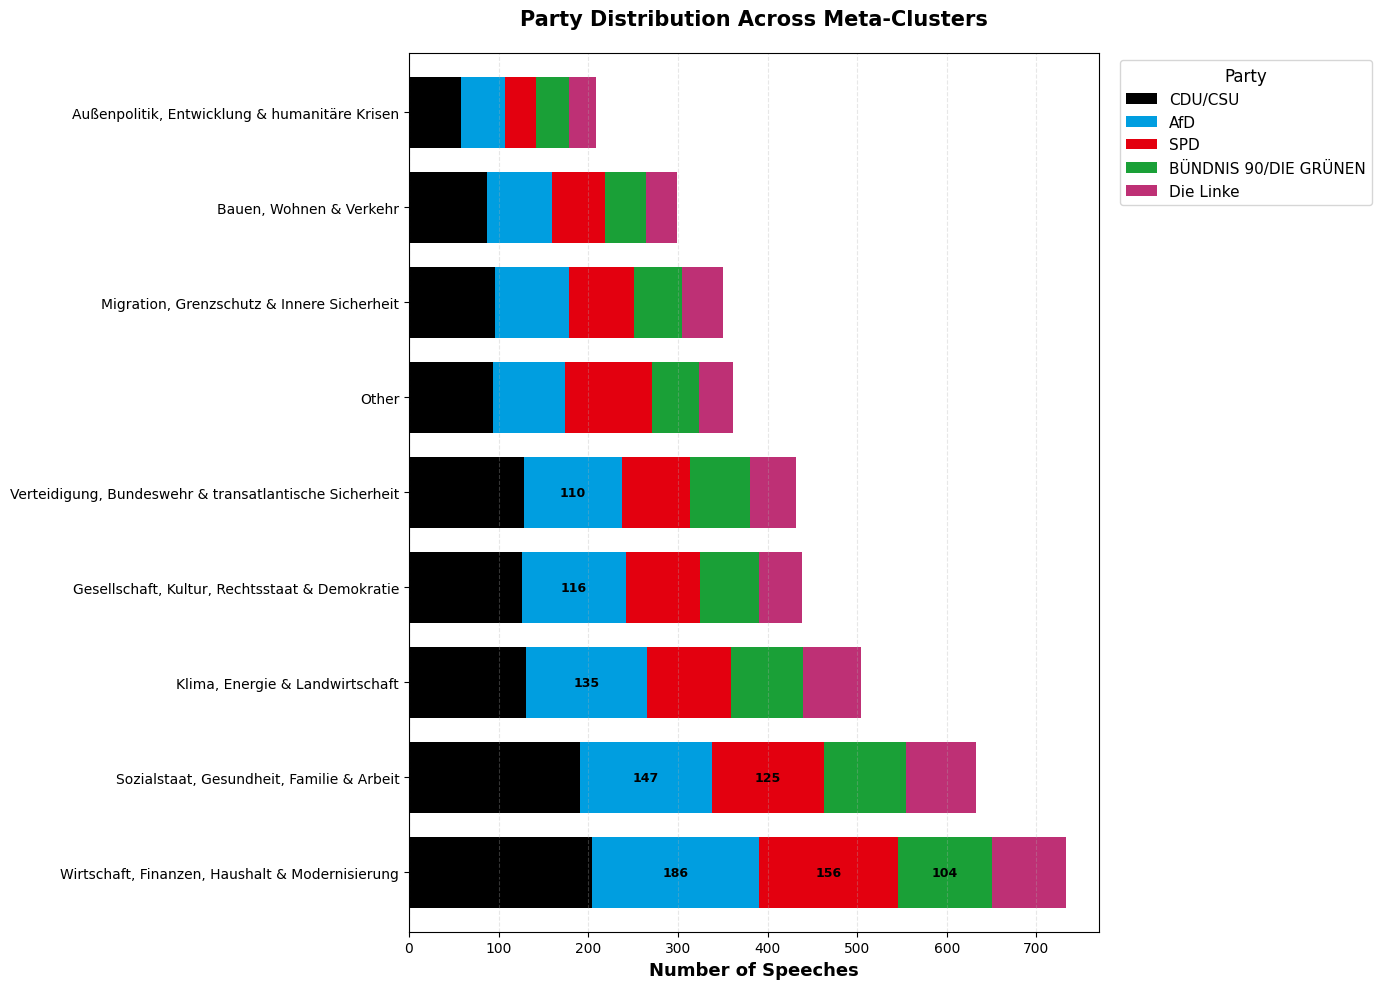

In [64]:
# =============================================================================
# PART E: GEOMETRY + SNA USING SEMANTIC CLUSTERS AND EMBEDDINGS
# =============================================================================
# 
# This analysis explores political polarization through the lens of semantic 
# embeddings. We compute party centroids in embedding space and measure 
# distances between parties within each thematic cluster.

print("="*80)
print("PART E: GEOMETRY + SNA - SEMANTIC POLARIZATION ANALYSIS")
print("="*80)

# -----------------------------------------------------------------------------
# E.0: Setup and Meta-Cluster Mapping
# -----------------------------------------------------------------------------

# Define meta-cluster mapping (aggregating 30 clusters into 8 thematic areas)
meta_map = {
    # 1) Sozialstaat, Gesundheit, Familie & Arbeit
    0: "Sozialstaat, Gesundheit, Familie & Arbeit",
    15: "Sozialstaat, Gesundheit, Familie & Arbeit",
    18: "Sozialstaat, Gesundheit, Familie & Arbeit",
    19: "Sozialstaat, Gesundheit, Familie & Arbeit",
    13: "Sozialstaat, Gesundheit, Familie & Arbeit",
    11: "Sozialstaat, Gesundheit, Familie & Arbeit",
    
    # 2) Bauen, Wohnen & Verkehr
    3: "Bauen, Wohnen & Verkehr",
    4: "Bauen, Wohnen & Verkehr",
    7: "Bauen, Wohnen & Verkehr",
    
    # 3) Klima, Energie & Landwirtschaft
    25: "Klima, Energie & Landwirtschaft",
    8: "Klima, Energie & Landwirtschaft",
    
    # 4) Wirtschaft, Finanzen, Haushalt & Modernisierung
    29: "Wirtschaft, Finanzen, Haushalt & Modernisierung",
    28: "Wirtschaft, Finanzen, Haushalt & Modernisierung",
    27: "Wirtschaft, Finanzen, Haushalt & Modernisierung",
    10: "Wirtschaft, Finanzen, Haushalt & Modernisierung",
    12: "Wirtschaft, Finanzen, Haushalt & Modernisierung",
    
    # 5) Gesellschaft, Kultur, Rechtsstaat & Demokratie
    17: "Gesellschaft, Kultur, Rechtsstaat & Demokratie",
    20: "Gesellschaft, Kultur, Rechtsstaat & Demokratie",
    6: "Gesellschaft, Kultur, Rechtsstaat & Demokratie",
    16: "Gesellschaft, Kultur, Rechtsstaat & Demokratie",
    5: "Gesellschaft, Kultur, Rechtsstaat & Demokratie",
    
    # 6) Migration, Grenzschutz & Innere Sicherheit
    21: "Migration, Grenzschutz & Innere Sicherheit",
    
    # 7) Verteidigung, Bundeswehr & transatlantische Sicherheit
    22: "Verteidigung, Bundeswehr & transatlantische Sicherheit",
    23: "Verteidigung, Bundeswehr & transatlantische Sicherheit",
    26: "Verteidigung, Bundeswehr & transatlantische Sicherheit",
    1: "Verteidigung, Bundeswehr & transatlantische Sicherheit",
    2: "Verteidigung, Bundeswehr & transatlantische Sicherheit",
    
    # 8) Außenpolitik, Entwicklung & humanitäre Krisen
    9: "Außenpolitik, Entwicklung & humanitäre Krisen",
    24: "Außenpolitik, Entwicklung & humanitäre Krisen",
    14: "Außenpolitik, Entwicklung & humanitäre Krisen",
}

# Apply meta-cluster mapping
df_speeches["meta_cluster"] = df_speeches["cluster_id"].map(meta_map).fillna("Other")

# Filter to parliamentary parties only (exclude government officials)
df_parl = df_speeches[df_speeches['speaker_type'] == 'Parliament'].copy()

# Clean up party names
df_parl['speaker_category'] = df_parl['speaker_category'].replace({
    'SPDSPD': 'SPD',  # Fix duplicate SPD
    'BÜNDNIS\xa090/DIE GRÜNEN': 'BÜNDNIS 90/DIE GRÜNEN',
    'Bündnis\xa090/Die Grünen': 'BÜNDNIS 90/DIE GRÜNEN',
})

# Remove fraktionslos (independent MPs)
df_parl = df_parl[df_parl['speaker_category'] != 'fraktionslos'].copy()

# Ensure date column exists and is properly formatted
# Force re-parsing to ensure it's in datetime format
df_parl['date'] = pd.to_datetime(df_parl['session_date'], format='%d.%m.%Y', errors='coerce')

# Create year_month column
df_parl['year_month'] = df_parl['date'].dt.to_period('M').astype(str)

# Get list of parties and meta-clusters
parties = df_parl['speaker_category'].unique()
meta_clusters = [mc for mc in df_parl['meta_cluster'].unique() if mc != "Other"]

print(f"\n✓ Meta-cluster mapping applied")
print(f"✓ Filtered to parliamentary speeches: {len(df_parl):,} speeches")
print(f"✓ Parties: {sorted(parties)}")
print(f"✓ Meta-clusters: {sorted(meta_clusters)}")
print(f"✓ Time range: {df_parl['year_month'].min()} to {df_parl['year_month'].max()}")

# Summary table
print("\n" + "-"*60)
print("META-CLUSTER SUMMARY")
print("-"*60)
meta_summary = df_parl.groupby('meta_cluster').agg(
    speeches=('speech_id', 'count'),
    parties=('speaker_category', 'nunique'),
    months=('year_month', 'nunique')
).sort_values('speeches', ascending=False)
print(meta_summary.to_string())

# Party distribution visualization
# Create party-cluster cross-tabulation
party_cluster_counts = df_parl.groupby(['meta_cluster', 'speaker_category']).size().reset_index(name='count')
party_cluster_pivot = party_cluster_counts.pivot(index='meta_cluster', columns='speaker_category', values='count').fillna(0)

# Sort by total speeches
cluster_totals = party_cluster_pivot.sum(axis=1).sort_values(ascending=False)
party_cluster_pivot = party_cluster_pivot.loc[cluster_totals.index]

# Define party colors
party_colors = {
    'SPD': '#E3000F',
    'CDU/CSU': '#000000',
    'BÜNDNIS 90/DIE GRÜNEN': '#1AA037',
    'FDP': '#FFED00',
    'AfD': '#009EE0',
    'Die Linke': '#BE3075',
}

# Sort parties by total speeches
party_totals = party_cluster_pivot.sum(axis=0).sort_values(ascending=False)
sorted_parties = party_totals.index.tolist()

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 10))

party_cluster_pivot[sorted_parties].plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=[party_colors.get(p, '#999999') for p in sorted_parties],
    width=0.75
)

ax.set_xlabel('Number of Speeches', fontsize=13, fontweight='bold')
ax.set_ylabel('')
ax.set_title('Party Distribution Across Meta-Clusters', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Party', bbox_to_anchor=(1.02, 1), loc='upper left', 
          frameon=True, fontsize=11, title_fontsize=12)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels for larger segments
for container in ax.containers:
    labels = [f'{int(v):,}' if v > 100 else '' for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [65]:
# -----------------------------------------------------------------------------
# E.1: Core Functions for Polarization Analysis
# -----------------------------------------------------------------------------

from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

MIN_SPEECHES_FOR_CENTROID = 3  # Minimum speeches to compute a valid centroid

def compute_party_centroids(df_subset, embeddings_full, df_full_index):
    """
    Compute party centroids (mean embeddings) for a subset of speeches.
    
    Args:
        df_subset: DataFrame subset (filtered by cluster/time)
        embeddings_full: Full embeddings matrix
        df_full_index: Index mapping from df_subset to embeddings
    
    Returns:
        dict: {party: centroid_vector} for parties with >= MIN_SPEECHES_FOR_CENTROID
    """
    centroids = {}
    party_counts = {}
    
    for party in df_subset['speaker_category'].unique():
        party_mask = df_subset['speaker_category'] == party
        party_indices = df_subset[party_mask].index
        
        # Get embedding indices (position in the full matrix)
        embedding_indices = [df_full_index.get_loc(idx) for idx in party_indices 
                           if idx in df_full_index]
        
        if len(embedding_indices) >= MIN_SPEECHES_FOR_CENTROID:
            party_embeddings = embeddings_full[embedding_indices]
            centroids[party] = party_embeddings.mean(axis=0)
            party_counts[party] = len(embedding_indices)
    
    return centroids, party_counts


def compute_pairwise_distances(centroids):
    """
    Compute pairwise cosine distances between party centroids.
    
    Returns:
        dict: {(party_a, party_b): distance}
        float: mean distance (polarization score)
    """
    if len(centroids) < 2:
        return {}, np.nan
    
    parties = list(centroids.keys())
    distances = {}
    
    for party_a, party_b in combinations(parties, 2):
        # Cosine similarity -> Cosine distance
        sim = cosine_similarity(
            centroids[party_a].reshape(1, -1),
            centroids[party_b].reshape(1, -1)
        )[0, 0]
        distance = 1 - sim  # Convert to distance
        distances[(party_a, party_b)] = distance
    
    mean_distance = np.mean(list(distances.values())) if distances else np.nan
    return distances, mean_distance


def get_extreme_pairs(distances, n=3):
    """
    Get the most distant (conflict) and closest (consensus) party pairs.
    """
    if not distances:
        return [], []
    
    sorted_pairs = sorted(distances.items(), key=lambda x: x[1], reverse=True)
    most_distant = sorted_pairs[:n]  # Highest distance = most conflict
    most_similar = sorted_pairs[-n:][::-1]  # Lowest distance = most consensus
    
    return most_distant, most_similar


print("✓ Core analysis functions defined:")
print("  - compute_party_centroids(): Calculate mean embeddings per party")
print("  - compute_pairwise_distances(): Cosine distance between centroids")
print("  - get_extreme_pairs(): Find conflict/consensus party pairs")


✓ Core analysis functions defined:
  - compute_party_centroids(): Calculate mean embeddings per party
  - compute_pairwise_distances(): Cosine distance between centroids
  - get_extreme_pairs(): Find conflict/consensus party pairs


In [66]:
# -----------------------------------------------------------------------------
# E.2: OUTPUT 1 - Conflict/Consensus Ranking per Meta-Cluster
# -----------------------------------------------------------------------------
# Compute overall polarization score for each thematic area

print("\n" + "="*80)
print("OUTPUT 1: CONFLICT/CONSENSUS RANKING PER TOPIC")
print("="*80)

# Get index mapping for embeddings
df_full_index = df_speeches.index

# Compute polarization for each meta-cluster
polarization_results = []

for meta_cluster in sorted(meta_clusters):
    # Filter speeches for this meta-cluster
    cluster_mask = df_parl['meta_cluster'] == meta_cluster
    df_cluster = df_parl[cluster_mask]
    
    if len(df_cluster) < 10:  # Skip very small clusters
        continue
    
    # Compute party centroids
    centroids, party_counts = compute_party_centroids(
        df_cluster, embeddings_openai, df_full_index
    )
    
    # Compute pairwise distances
    distances, mean_polarization = compute_pairwise_distances(centroids)
    
    # Get extreme pairs
    most_distant, most_similar = get_extreme_pairs(distances, n=2)
    
    polarization_results.append({
        'meta_cluster': meta_cluster,
        'polarization_score': mean_polarization,
        'n_speeches': len(df_cluster),
        'n_parties_with_data': len(centroids),
        'party_counts': party_counts,
        'distances': distances,
        'most_distant': most_distant,
        'most_similar': most_similar
    })

# Create ranking DataFrame
df_polarization = pd.DataFrame(polarization_results)
df_polarization = df_polarization.sort_values('polarization_score', ascending=False)

# Display ranking table
print("\n" + "-"*70)
print("POLARIZATION RANKING (Higher = More Conflict)")
print("-"*70)
print(f"{'Meta-Cluster':<35} {'Score':>10} {'Speeches':>10} {'Parties':>8}")
print("-"*70)

for _, row in df_polarization.iterrows():
    print(f"{row['meta_cluster']:<35} {row['polarization_score']:>10.4f} {row['n_speeches']:>10} {row['n_parties_with_data']:>8}")

# Highlight top 3 conflict and consensus fields
print("\n" + "="*70)
print("🔥 TOP 3 CONFLICT FIELDS (highest polarization):")
print("="*70)
for i, (_, row) in enumerate(df_polarization.head(3).iterrows(), 1):
    print(f"\n{i}. {row['meta_cluster']} (Score: {row['polarization_score']:.4f})")
    if row['most_distant']:
        for (p1, p2), dist in row['most_distant'][:2]:
            print(f"   → Biggest Conflict: {p1} vs {p2} (Distance: {dist:.4f})")

print("\n" + "="*70)
print("🤝 TOP 3 CONSENSUS FIELDS (lowest polarization):")
print("="*70)
for i, (_, row) in enumerate(df_polarization.tail(3).iloc[::-1].iterrows(), 1):
    print(f"\n{i}. {row['meta_cluster']} (Score: {row['polarization_score']:.4f})")
    if row['most_similar']:
        for (p1, p2), dist in row['most_similar'][:2]:
            print(f"   → Highest Consensus: {p1} & {p2} (Distance: {dist:.4f})")



OUTPUT 1: CONFLICT/CONSENSUS RANKING PER TOPIC

----------------------------------------------------------------------
POLARIZATION RANKING (Higher = More Conflict)
----------------------------------------------------------------------
Meta-Cluster                             Score   Speeches  Parties
----------------------------------------------------------------------
Bauen, Wohnen & Verkehr                 0.0391        299        5
Außenpolitik, Entwicklung & humanitäre Krisen     0.0386        209        5
Wirtschaft, Finanzen, Haushalt & Modernisierung     0.0318        733        5
Klima, Energie & Landwirtschaft         0.0312        504        5
Migration, Grenzschutz & Innere Sicherheit     0.0280        350        5
Sozialstaat, Gesundheit, Familie & Arbeit     0.0270        633        5
Verteidigung, Bundeswehr & transatlantische Sicherheit     0.0260        432        5
Gesellschaft, Kultur, Rechtsstaat & Demokratie     0.0179        438        5

🔥 TOP 3 CONFLICT FIELDS

In [67]:
# -----------------------------------------------------------------------------
# E.3: OUTPUT 2 - Polarization Over Time (per Meta-Cluster)
# -----------------------------------------------------------------------------
# Track how polarization evolves month by month for each thematic area

print("\n" + "="*80)
print("OUTPUT 2: POLARIZATION OVER TIME")
print("="*80)

# Get all months in chronological order
all_months = sorted(df_parl['year_month'].unique())
print(f"\nAnalyzing {len(all_months)} months: {all_months[0]} to {all_months[-1]}")

# Compute time series for each meta-cluster
time_series_data = []

for meta_cluster in sorted(meta_clusters):
    cluster_mask = df_parl['meta_cluster'] == meta_cluster
    df_cluster = df_parl[cluster_mask]
    
    for month in all_months:
        month_mask = df_cluster['year_month'] == month
        df_month = df_cluster[month_mask]
        
        if len(df_month) < 5:  # Skip months with too few speeches
            continue
        
        # Compute centroids and distances for this month
        centroids, party_counts = compute_party_centroids(
            df_month, embeddings_openai, df_full_index
        )
        
        distances, mean_polarization = compute_pairwise_distances(centroids)
        
        if not np.isnan(mean_polarization):
            time_series_data.append({
                'meta_cluster': meta_cluster,
                'month': month,
                'polarization': mean_polarization,
                'n_speeches': len(df_month),
                'n_parties': len(centroids)
            })

df_time_series = pd.DataFrame(time_series_data)

# Pivot for easier plotting
df_pivot = df_time_series.pivot(
    index='month', 
    columns='meta_cluster', 
    values='polarization'
)

print(f"\n✓ Computed {len(df_time_series)} data points across all meta-clusters")
print(f"✓ Time series covers {len(df_pivot)} months")



OUTPUT 2: POLARIZATION OVER TIME

Analyzing 8 months: 2025-03 to 2025-12

✓ Computed 54 data points across all meta-clusters
✓ Time series covers 7 months


/var/folders/pg/fh4vv34x15z05qrbsr36609r0000gn/T/ipykernel_23722/974427896.py:81: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jonasschreiner/.pyenv/versions/3.12.4/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


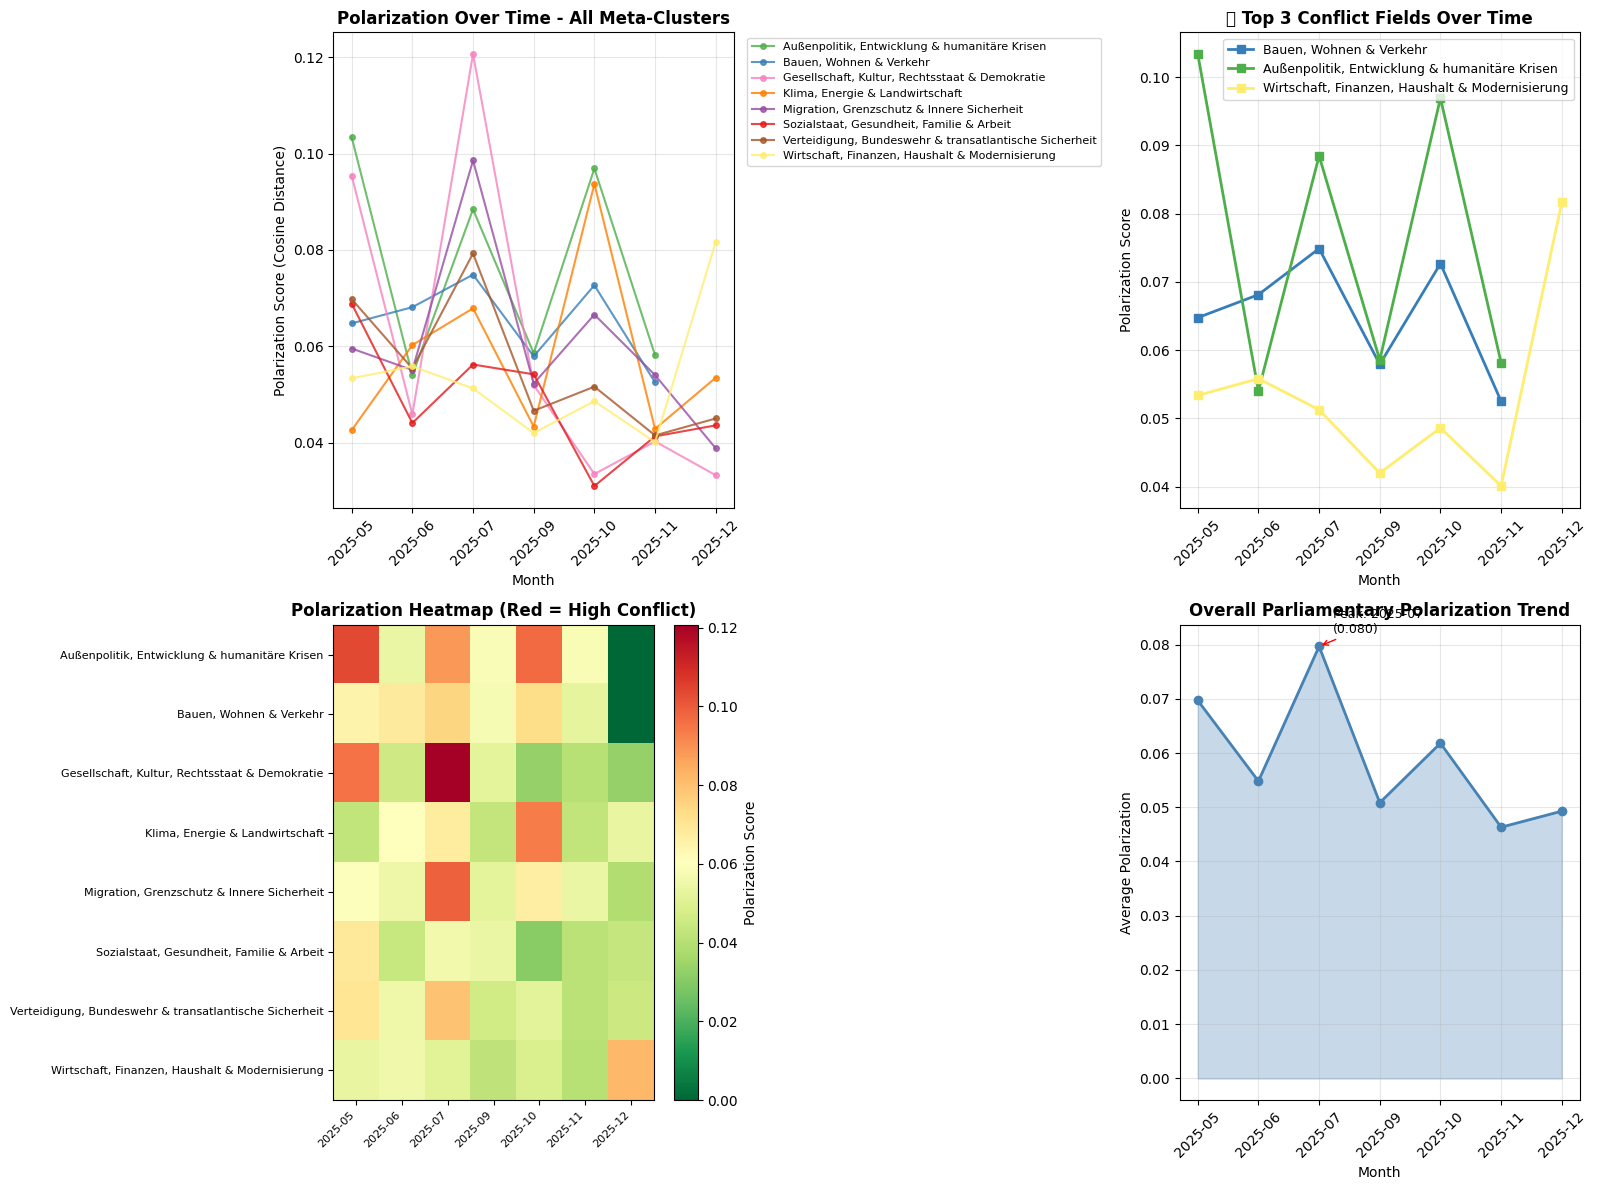

In [68]:
# -----------------------------------------------------------------------------
# E.3b: Visualization - Polarization Time Series
# -----------------------------------------------------------------------------

# Define colors for meta-clusters
cluster_colors = {
    "Sozialstaat, Gesundheit, Familie & Arbeit": "#e41a1c",
    "Bauen, Wohnen & Verkehr": "#377eb8",
    "Klima, Energie & Landwirtschaft": "#ff7f00",
    "Wirtschaft, Finanzen, Haushalt & Modernisierung": "#ffed6f",
    "Gesellschaft, Kultur, Rechtsstaat & Demokratie": "#f781bf",
    "Migration, Grenzschutz & Innere Sicherheit": "#984ea3",
    "Verteidigung, Bundeswehr & transatlantische Sicherheit": "#a65628",
    "Außenpolitik, Entwicklung & humanitäre Krisen": "#4daf4a",
}

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All meta-clusters on one plot
ax1 = axes[0, 0]
for meta_cluster in df_pivot.columns:
    color = cluster_colors.get(meta_cluster, '#333333')
    ax1.plot(df_pivot.index, df_pivot[meta_cluster], 
             marker='o', markersize=4, label=meta_cluster, color=color, alpha=0.8)

ax1.set_xlabel('Month', fontsize=10)
ax1.set_ylabel('Polarization Score (Cosine Distance)', fontsize=10)
ax1.set_title('Polarization Over Time - All Meta-Clusters', fontsize=12, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Top 3 conflict clusters highlighted
ax2 = axes[0, 1]
top3_conflict = df_polarization.head(3)['meta_cluster'].tolist()
for meta_cluster in top3_conflict:
    if meta_cluster in df_pivot.columns:
        color = cluster_colors.get(meta_cluster, '#333333')
        ax2.plot(df_pivot.index, df_pivot[meta_cluster], 
                 marker='s', markersize=6, label=meta_cluster, color=color, linewidth=2)

ax2.set_xlabel('Month', fontsize=10)
ax2.set_ylabel('Polarization Score', fontsize=10)
ax2.set_title('🔥 Top 3 Conflict Fields Over Time', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Plot 3: Heatmap of polarization over time
ax3 = axes[1, 0]
heatmap_data = df_pivot.T.fillna(0)
im = ax3.imshow(heatmap_data.values, aspect='auto', cmap='RdYlGn_r')
ax3.set_yticks(range(len(heatmap_data.index)))
ax3.set_yticklabels(heatmap_data.index, fontsize=8)
ax3.set_xticks(range(len(heatmap_data.columns)))
ax3.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=8)
ax3.set_title('Polarization Heatmap (Red = High Conflict)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax3, label='Polarization Score')

# Plot 4: Average polarization trend
ax4 = axes[1, 1]
avg_polarization = df_pivot.mean(axis=1)
ax4.fill_between(avg_polarization.index, avg_polarization.values, alpha=0.3, color='steelblue')
ax4.plot(avg_polarization.index, avg_polarization.values, 
         marker='o', color='steelblue', linewidth=2, markersize=6)
ax4.set_xlabel('Month', fontsize=10)
ax4.set_ylabel('Average Polarization', fontsize=10)
ax4.set_title('Overall Parliamentary Polarization Trend', fontsize=12, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# Add trend annotation
max_month = avg_polarization.idxmax()
max_val = avg_polarization.max()
ax4.annotate(f'Peak: {max_month}\n({max_val:.3f})', 
             xy=(list(avg_polarization.index).index(max_month), max_val),
             xytext=(10, 10), textcoords='offset points',
             fontsize=9, arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

In [69]:
# -----------------------------------------------------------------------------
# E.4: OUTPUT 3 - Party Pairs: Opponents and Allies per Topic
# -----------------------------------------------------------------------------
# For each meta-cluster, identify which party pairs are most distant (opponents)
# and which are closest (surprising allies)

print("\n" + "="*80)
print("OUTPUT 3: PARTY PAIRS - OPPONENTS & ALLIES PER TOPIC")
print("="*80)

# Collect all party pair data
party_pair_analysis = []

for result in polarization_results:
    meta_cluster = result['meta_cluster']
    distances = result['distances']
    
    if not distances:
        continue
    
    # Get all pairs with distances
    for (party_a, party_b), distance in distances.items():
        party_pair_analysis.append({
            'meta_cluster': meta_cluster,
            'party_a': party_a,
            'party_b': party_b,
            'distance': distance,
            'pair': f"{party_a} vs {party_b}"
        })

df_pairs = pd.DataFrame(party_pair_analysis)

# Print detailed analysis for each meta-cluster
print("\n" + "="*80)
print("DETAILED PARTY PAIR ANALYSIS PER TOPIC")
print("="*80)

for meta_cluster in sorted(df_pairs['meta_cluster'].unique()):
    cluster_data = df_pairs[df_pairs['meta_cluster'] == meta_cluster].sort_values('distance', ascending=False)
    
    print(f"\n{'─'*70}")
    print(f"📊 {meta_cluster.upper()}")
    print(f"{'─'*70}")
    
    # Most distant (opponents)
    print("\n  🔴 OPPONENTS (highest distance):")
    for i, (_, row) in enumerate(cluster_data.head(3).iterrows(), 1):
        print(f"     {i}. {row['party_a']} ↔ {row['party_b']}: {row['distance']:.4f}")
    
    # Most similar (allies/surprising consensus)
    print("\n  🟢 UNEXPECTED ALLIES (lowest distance):")
    for i, (_, row) in enumerate(cluster_data.tail(3).iloc[::-1].iterrows(), 1):
        print(f"     {i}. {row['party_a']} & {row['party_b']}: {row['distance']:.4f}")



OUTPUT 3: PARTY PAIRS - OPPONENTS & ALLIES PER TOPIC

DETAILED PARTY PAIR ANALYSIS PER TOPIC

──────────────────────────────────────────────────────────────────────
📊 AUSSENPOLITIK, ENTWICKLUNG & HUMANITÄRE KRISEN
──────────────────────────────────────────────────────────────────────

  🔴 OPPONENTS (highest distance):
     1. BÜNDNIS 90/DIE GRÜNEN ↔ AfD: 0.0598
     2. SPD ↔ AfD: 0.0568
     3. Die Linke ↔ AfD: 0.0509

  🟢 UNEXPECTED ALLIES (lowest distance):
     1. SPD & BÜNDNIS 90/DIE GRÜNEN: 0.0182
     2. BÜNDNIS 90/DIE GRÜNEN & Die Linke: 0.0207
     3. SPD & CDU/CSU: 0.0216

──────────────────────────────────────────────────────────────────────
📊 BAUEN, WOHNEN & VERKEHR
──────────────────────────────────────────────────────────────────────

  🔴 OPPONENTS (highest distance):
     1. AfD ↔ SPD: 0.0581
     2. CDU/CSU ↔ Die Linke: 0.0526
     3. CDU/CSU ↔ AfD: 0.0509

  🟢 UNEXPECTED ALLIES (lowest distance):
     1. CDU/CSU & SPD: 0.0144
     2. BÜNDNIS 90/DIE GRÜNEN & Die Linke: 

In [70]:
# -----------------------------------------------------------------------------
# E.4b: Cross-Topic Party Pair Comparison
# -----------------------------------------------------------------------------
# Find party pairs that have very different relationships across topics

print("\n" + "="*80)
print("CROSS-TOPIC PARTY PAIR COMPARISON")
print("="*80)
print("Which party pairs have varying relationships across different topics?")

# Pivot to get distance per pair per topic
df_pairs_pivot = df_pairs.pivot_table(
    index='pair', 
    columns='meta_cluster', 
    values='distance',
    aggfunc='mean'
)

# Calculate variance in distance across topics for each pair
pair_variance = df_pairs_pivot.var(axis=1).sort_values(ascending=False)

print("\n" + "-"*70)
print("MOST VARIABLE PARTY PAIRS (different relationships across topics)")
print("-"*70)
print("High variance = pair is close in some topics, far in others")
print()

for pair, variance in pair_variance.head(10).items():
    pair_distances = df_pairs_pivot.loc[pair].dropna()
    min_dist = pair_distances.min()
    max_dist = pair_distances.max()
    min_topic = pair_distances.idxmin()
    max_topic = pair_distances.idxmax()
    
    print(f"📊 {pair}")
    print(f"   Variance: {variance:.5f}")
    print(f"   🟢 Closest in: {min_topic} ({min_dist:.4f})")
    print(f"   🔴 Farthest in: {max_topic} ({max_dist:.4f})")
    print()

# Find interesting storylines
print("\n" + "="*80)
print("🎯 NOTABLE STORYLINES")
print("="*80)

for pair, variance in pair_variance.head(20).items():
    # Check if pair involves major parties
    if any(p in pair for p in ['CDU/CSU', 'SPD', 'AfD', 'GRÜNEN']):
        pair_distances = df_pairs_pivot.loc[pair].dropna()
        if len(pair_distances) >= 3:
            min_dist = pair_distances.min()
            max_dist = pair_distances.max()
            min_topic = pair_distances.idxmin()
            max_topic = pair_distances.idxmax()
            
            if max_dist - min_dist > 0.02:  # Significant difference
                print(f"\n→ {pair}:")
                print(f"  • Close in '{min_topic}' (distance: {min_dist:.4f})")
                print(f"  • Far apart in '{max_topic}' (distance: {max_dist:.4f})")
                print(f"  • Interpretation: Agreement on {min_topic.lower()}, conflict on {max_topic.lower()}")



CROSS-TOPIC PARTY PAIR COMPARISON
Which party pairs have varying relationships across different topics?

----------------------------------------------------------------------
MOST VARIABLE PARTY PAIRS (different relationships across topics)
----------------------------------------------------------------------
High variance = pair is close in some topics, far in others

📊 BÜNDNIS 90/DIE GRÜNEN vs AfD
   Variance: 0.00029
   🟢 Closest in: Migration, Grenzschutz & Innere Sicherheit (0.0358)
   🔴 Farthest in: Außenpolitik, Entwicklung & humanitäre Krisen (0.0598)

📊 AfD vs SPD
   Variance: 0.00017
   🟢 Closest in: Gesellschaft, Kultur, Rechtsstaat & Demokratie (0.0223)
   🔴 Farthest in: Bauen, Wohnen & Verkehr (0.0581)

📊 SPD vs AfD
   Variance: 0.00014
   🟢 Closest in: Migration, Grenzschutz & Innere Sicherheit (0.0400)
   🔴 Farthest in: Außenpolitik, Entwicklung & humanitäre Krisen (0.0568)

📊 CDU/CSU vs Die Linke
   Variance: 0.00014
   🟢 Closest in: Gesellschaft, Kultur, Rechtsstaat

In [71]:
# =============================================================================
# PART E.2: SOCIAL NETWORK ANALYSIS (SNA) - PARTY SIMILARITY NETWORK
# =============================================================================
# 
# Build a graph where:
#   - Nodes = Parties
#   - Edge weights = Cosine similarity between party centroids
#
# Analysis:
#   - Centrality measures (weighted degree, betweenness)
#   - Community detection (greedy modularity)
# =============================================================================

import networkx as nx
from networkx.algorithms import community as nx_community

print("="*80)
print("PART E.2: SOCIAL NETWORK ANALYSIS - PARTY SIMILARITY NETWORK BASED ON CLUSTER-LEVEL CENTROIDS")
print("="*80)

# Assumes you already have:
# - df_speeches (with cluster_id, speaker_type, speaker_category, session_date, etc.)
# - embeddings_openai (aligned to df_speeches rows via index mapping)
# - RESULTS_DIR defined

# 1) Filter to parliamentary speeches
df_parl = df_speeches[df_speeches["speaker_type"] == "Parliament"].copy()

# 2) Clean party names (example fix)
df_parl["speaker_category"] = df_parl["speaker_category"].replace({
    "SPDSPD": "SPD",
})

# 3) Remove fraktionslos / independents
df_parl = df_parl[df_parl["speaker_category"] != "fraktionslos"].copy()

# 4) Cluster filter: exclude noise
df_parl = df_parl[df_parl["cluster_id"] != -1].copy()

# 5) Collect parties
parties = sorted(df_parl["speaker_category"].unique())

print(f"✓ Parliamentary speeches (clustered only): {len(df_parl):,}")
print(f"✓ Parties: {parties}")

# Index mapping for embeddings
df_full_index = df_speeches.index
assert len(df_full_index) == embeddings_openai.shape[0], "embeddings_openai must align with df_speeches rows"
print("✓ Embedding alignment looks OK")

PART E.2: SOCIAL NETWORK ANALYSIS - PARTY SIMILARITY NETWORK BASED ON CLUSTER-LEVEL CENTROIDS
✓ Parliamentary speeches (clustered only): 3,598
✓ Parties: ['AfD', 'BÜNDNIS\xa090/DIE GRÜNEN', 'CDU/CSU', 'Die Linke', 'SPD']
✓ Embedding alignment looks OK


In [72]:
# Core helper functions (centroids + pairwise cosine similarity)
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

MIN_PER_PARTY_PER_CLUSTER = 5  # important for stability

def compute_party_centroids_in_subset(df_subset, embeddings_full, df_full_index, parties):
    """
    Returns:
      centroids: dict party -> centroid (np.array)
      counts: dict party -> n speeches used
    """
    centroids = {}
    counts = {}

    for p in parties:
        idx = df_subset.index[df_subset["speaker_category"] == p]
        if len(idx) < MIN_PER_PARTY_PER_CLUSTER:
            continue

        emb_idx = [df_full_index.get_loc(i) for i in idx if i in df_full_index]
        if len(emb_idx) < MIN_PER_PARTY_PER_CLUSTER:
            continue

        centroids[p] = embeddings_full[emb_idx].mean(axis=0)
        counts[p] = len(emb_idx)

    return centroids, counts


def cosine_sim(a, b):
    return float(cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0, 0])

print("✓ Helper functions ready")

✓ Helper functions ready


In [73]:
# Pair-specific weighted aggregation across clusters
print("="*80)
print("STEP 1: BUILD PAIR-WEIGHTED SIMILARITY MATRIX (AGGREGATED OVER CLUSTERS)")
print("="*80)

cluster_ids = sorted(df_parl["cluster_id"].unique())

# accumulators for weighted mean per pair
acc = {(p, q): 0.0 for p in parties for q in parties}
wacc = {(p, q): 0.0 for p in parties for q in parties}

clusters_used = 0
pairs_observed = set()

for cid in cluster_ids:
    df_c = df_parl[df_parl["cluster_id"] == cid]
    if len(df_c) < 10:
        continue

    centroids, counts = compute_party_centroids_in_subset(df_c, embeddings_openai, df_full_index, parties)
    present = sorted(centroids.keys())
    if len(present) < 2:
        continue

    # compute pairwise similarities inside this cluster
    for p, q in combinations(present, 2):
        s = cosine_sim(centroids[p], centroids[q])

        # Variante C: pair-specific weight
        w = min(counts.get(p, 0), counts.get(q, 0))
        if w <= 0:
            continue

        acc[(p, q)] += w * s
        acc[(q, p)] += w * s
        wacc[(p, q)] += w
        wacc[(q, p)] += w
        pairs_observed.add((p, q))

    # diagonal (optional): keep 1.0 with any weight (not needed but nice)
    for p in present:
        acc[(p, p)] += 1.0
        wacc[(p, p)] += 1.0

    clusters_used += 1

# finalize matrix
M = np.full((len(parties), len(parties)), np.nan, dtype=float)
for i, p in enumerate(parties):
    for j, q in enumerate(parties):
        if wacc[(p, q)] > 0:
            M[i, j] = acc[(p, q)] / wacc[(p, q)]

df_sim_pair_weighted = pd.DataFrame(M, index=parties, columns=parties)

print(f"✓ Clusters used: {clusters_used} / {len(cluster_ids)}")
print(f"✓ Pairs observed at least once: {len(pairs_observed)} / {len(parties)*(len(parties)-1)//2}")
print("\nPair-weighted similarity matrix (rounded):")
print(df_sim_pair_weighted.round(4))

STEP 1: BUILD PAIR-WEIGHTED SIMILARITY MATRIX (AGGREGATED OVER CLUSTERS)
✓ Clusters used: 30 / 30
✓ Pairs observed at least once: 10 / 10

Pair-weighted similarity matrix (rounded):
                          AfD  BÜNDNIS 90/DIE GRÜNEN  CDU/CSU  Die Linke  \
AfD                    1.0000                 0.9525   0.9551     0.9511   
BÜNDNIS 90/DIE GRÜNEN  0.9525                 1.0000   0.9614     0.9685   
CDU/CSU                0.9551                 0.9614   1.0000     0.9466   
Die Linke              0.9511                 0.9685   0.9466     1.0000   
SPD                    0.9471                 0.9673   0.9779     0.9548   

                          SPD  
AfD                    0.9471  
BÜNDNIS 90/DIE GRÜNEN  0.9673  
CDU/CSU                0.9779  
Die Linke              0.9548  
SPD                    1.0000  


In [74]:
# Build network from pair-weighted similarities
import networkx as nx

print("="*80)
print("STEP 2: BUILD NETWORK (EDGE WEIGHT = PAIR-WEIGHTED COSINE SIMILARITY)")
print("="*80)

G = nx.Graph()

# add nodes
for p in parties:
    n_speeches = int((df_parl["speaker_category"] == p).sum())
    G.add_node(p, n_speeches=n_speeches)

# add edges (skip NaNs)
for i, p in enumerate(parties):
    for j, q in enumerate(parties):
        if i >= j:
            continue
        s = df_sim_pair_weighted.loc[p, q]
        if np.isnan(s):
            continue
        # distance for shortest-path metrics
        d = float(1.0 - s)
        G.add_edge(p, q, weight=float(s), similarity=float(s), distance=d)

print(f"✓ Nodes: {G.number_of_nodes()}")
print(f"✓ Edges: {G.number_of_edges()} (NaN pairs omitted)")

STEP 2: BUILD NETWORK (EDGE WEIGHT = PAIR-WEIGHTED COSINE SIMILARITY)
✓ Nodes: 5
✓ Edges: 10 (NaN pairs omitted)


In [75]:
# Centrality measures (use similarity for strength/eigenvector, distance for betweenness/closeness)
from networkx.algorithms import community as nx_community

print("="*80)
print("STEP 3: CENTRALITY + COMMUNITY DETECTION")
print("="*80)

# Strength = weighted degree (similarity weights)
strength = dict(G.degree(weight="weight"))

# Betweenness: use 'distance' as edge length
betweenness = nx.betweenness_centrality(G, weight="distance")

# Closeness: also use 'distance'
closeness = nx.closeness_centrality(G, distance="distance")

# Eigenvector: uses similarity weights
try:
    eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=2000)
except Exception as e:
    print("⚠️ Eigenvector centrality failed:", repr(e))
    eigenvector = {p: np.nan for p in parties}

# Community detection (greedy modularity) on similarity weights
communities = nx_community.greedy_modularity_communities(G, weight="weight")
modularity = nx_community.modularity(G, communities, weight="weight")

community_map = {}
for cid, comm in enumerate(communities):
    for p in comm:
        community_map[p] = cid

df_centrality = pd.DataFrame([
    {
        "party": p,
        "n_speeches": G.nodes[p]["n_speeches"],
        "strength": strength.get(p, np.nan),
        "betweenness": betweenness.get(p, np.nan),
        "closeness": closeness.get(p, np.nan),
        "eigenvector": eigenvector.get(p, np.nan),
        "community": community_map.get(p, np.nan),
    }
    for p in parties
]).sort_values("strength", ascending=False)

print("\nCentrality ranking (by strength):")
print(df_centrality.round(4).to_string(index=False))

print(f"\nCommunities found: {len(communities)}")
print(f"Modularity: {modularity:.4f}")


STEP 3: CENTRALITY + COMMUNITY DETECTION

Centrality ranking (by strength):
                party  n_speeches  strength  betweenness  closeness  eigenvector  community
BÜNDNIS 90/DIE GRÜNEN         542    3.8497          0.0    26.6051       0.4488          0
                  SPD         699    3.8472          0.0    26.1734       0.4485          0
              CDU/CSU        1021    3.8411          0.0    25.1679       0.4480          0
            Die Linke         437    3.8210          0.0    22.3474       0.4461          0
                  AfD         899    3.8059          0.0    20.6042       0.4447          0

Communities found: 1
Modularity: 0.0000


STEP 4: VISUALIZATIONS (NETWORK + HEATMAP)


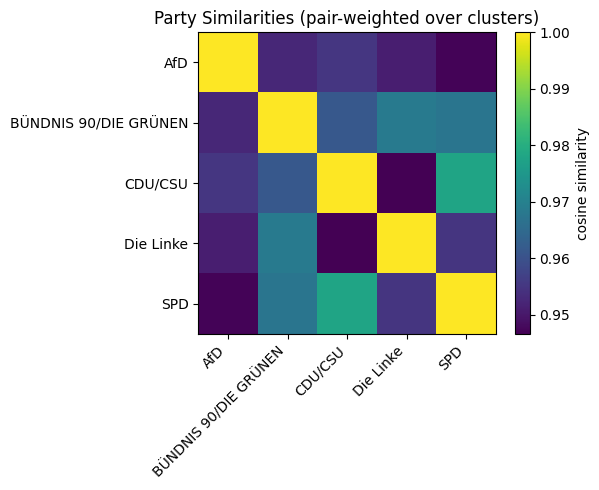

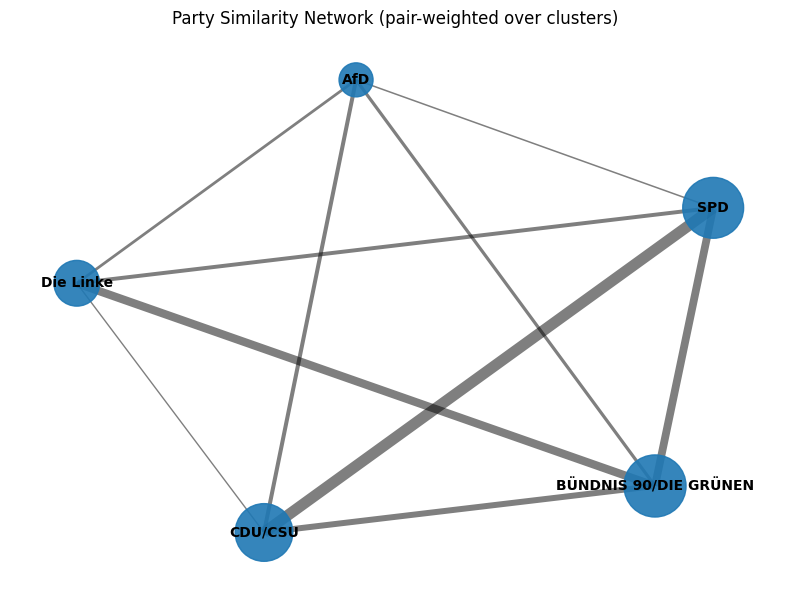

In [76]:
# Visualization (network + similarity heatmap)
import matplotlib.pyplot as plt

print("="*80)
print("STEP 4: VISUALIZATIONS (NETWORK + HEATMAP)")
print("="*80)

# --- 1) Similarity heatmap ---
plt.figure(figsize=(6, 5))
plt.imshow(df_sim_pair_weighted.values, aspect="auto")
plt.xticks(range(len(parties)), parties, rotation=45, ha="right")
plt.yticks(range(len(parties)), parties)
plt.title("Party Similarities (pair-weighted over clusters)")
plt.colorbar(label="cosine similarity")
plt.tight_layout()
plt.show()

# --- 2) Network plot ---
pos = nx.spring_layout(G, seed=42, weight="weight")

# node size by strength (scaled)
vals = np.array([strength[p] for p in parties], dtype=float)
if np.nanmax(vals) > np.nanmin(vals):
    node_sizes = 600 + 1400 * (vals - np.nanmin(vals)) / (np.nanmax(vals) - np.nanmin(vals))
else:
    node_sizes = np.full_like(vals, 1000.0)

# edge widths by similarity (scaled)
edge_list = list(G.edges())
edge_w = np.array([G[u][v]["weight"] for u, v in edge_list], dtype=float)
if len(edge_w) and edge_w.max() > edge_w.min():
    edge_widths = 1.0 + 7.0 * (edge_w - edge_w.min()) / (edge_w.max() - edge_w.min())
else:
    edge_widths = np.full(len(edge_list), 3.0)

plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
plt.title("Party Similarity Network (pair-weighted over clusters)")
plt.axis("off")
plt.tight_layout()
plt.show()